## Configuration: Toggle Plots

**Enable/Disable** specific exposure score comparisons below. Set to `True` to generate the plot, `False` to skip.

**Available Exposure Scores**:
- **occ_level.csv** (6 scores): Elondou et al. ratings by raters and LLM
- **pi_occ_level.csv** (3 scores): Alternative DV ratings 
- **pierre_occ_level.csv** (1 score): Pierre's consolidated rating

In [ ]:
# ============================================================================
# PLOT CONFIGURATION - Set True/False to enable/disable each plot
# ============================================================================

PLOT_CONFIG = {
    # From occ_level.csv (Eloundou et al.)
    "occ_dv_rating_alpha": True,
    "occ_dv_rating_beta": True,
    "occ_dv_rating_gamma": True,
    "occ_human_rating_alpha": True,
    "occ_human_rating_beta": True,
    "occ_human_rating_gamma": True,

    # From pi_occ_level.csv (π-weighted Eloundou labels)
    "pi_dv_rating_alpha": True,
    "pi_dv_rating_beta": True,
    "pi_dv_rating_gamma": True,

    # From pierre_occ_level.csv (single consolidated score)
    "pierre_dv_rating": True,
}

print("Plot Configuration:")
print("=" * 60)
for plot_name, enabled in PLOT_CONFIG.items():
    status = "✓ ENABLED" if enabled else "✗ DISABLED"
    print(f"{plot_name:30s} : {status}")
print("=" * 60)
print(f"Total plots enabled: {sum(PLOT_CONFIG.values())}/10")

Plot Configuration:
occ_dv_rating_alpha            : ✓ ENABLED
occ_dv_rating_beta             : ✓ ENABLED
occ_dv_rating_gamma            : ✓ ENABLED
occ_human_rating_alpha         : ✓ ENABLED
occ_human_rating_beta          : ✓ ENABLED
occ_human_rating_gamma         : ✓ ENABLED
pi_dv_rating_alpha             : ✓ ENABLED
pi_dv_rating_beta              : ✓ ENABLED
pi_dv_rating_gamma             : ✓ ENABLED
pierre_dv_rating               : ✓ ENABLED
Total plots enabled: 10/10


# Dow Jones Employment Analysis: AI Exposure and Labor Market Dynamics

This notebook analyzes employment trends across 30 Dow Jones companies from 2021-2025, examining how occupations with different levels of AI exposure evolved around the November 2022 ChatGPT release. We implement the Brynjolfsson et al. (2024) methodology to control for firm-level shocks using high-dimensional fixed effects.

## 0. Setup: Load Libraries and Data Sources

**Objective**: Import required packages and load AI exposure scores.

**Data Sources**:
- **Revelio Labs**: Position-level employment records (start/end dates, O*NET occupation codes)
- **Eloundou et al. (2023)**: Occupation-level AI exposure scores measuring LLM impact potential

**Key Variable**: `dv_rating_beta` - measures how exposed each occupation is to large language model capabilities.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pyfixest as pf
from pyfixest.estimation import feols, fepois

# Get the directory where the current notebook lives
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # works inside Jupyter

# ============================================================================
# Load all three exposure datasets
# ============================================================================

# Dataset 1: occ_level.csv (Eloundou et al. - 6 variables)
occ_exposure_df = pd.read_csv(os.path.join(notebook_dir,"..", "Data", "occ_level.csv"))
print(f"Loaded occ_level.csv: {len(occ_exposure_df)} occupations")

# Dataset 2: pi_occ_level.csv (3 variables)
pi_exposure_df = pd.read_csv(os.path.join(notebook_dir,"..", "Data", "pi_occ_level.csv"))
print(f"Loaded pi_occ_level.csv: {len(pi_exposure_df)} occupations")

# Dataset 3: pierre_occ_level.csv (1 variable)
pierre_exposure_df = pd.read_csv(os.path.join(notebook_dir,"..", "Data", "pierre_occ_level.csv"))
print(f"Loaded pierre_occ_level.csv: {len(pierre_exposure_df)} occupations")

# ============================================================================
# Create unified exposure dictionary for all variables
# ============================================================================

EXPOSURE_DATA = {
    # From occ_level.csv
    "occ_dv_rating_alpha": {"df": occ_exposure_df, "column": "dv_rating_alpha", "title": "Eloundou Rating Alpha"},
    "occ_dv_rating_beta":  {"df": occ_exposure_df, "column": "dv_rating_beta",  "title": "Eloundou Rating Beta"},
    "occ_dv_rating_gamma": {"df": occ_exposure_df, "column": "dv_rating_gamma", "title": "Eloundou Rating Gamma"},
    "occ_human_rating_alpha": {"df": occ_exposure_df, "column": "human_rating_alpha", "title": "Eloundou Human Rating Alpha"},
    "occ_human_rating_beta":  {"df": occ_exposure_df, "column": "human_rating_beta",  "title": "Eloundou Human Rating Beta"},
    "occ_human_rating_gamma": {"df": occ_exposure_df, "column": "human_rating_gamma", "title": "Eloundou Human Rating Gamma"},

    # From pi_occ_level.csv
    "pi_dv_rating_alpha": {"df": pi_exposure_df, "column": "pierre_alpha", "title": "π-weighted Rating Alpha"},
    "pi_dv_rating_beta":  {"df": pi_exposure_df, "column": "pierre_beta",  "title": "π-weighted Rating Beta"},
    "pi_dv_rating_gamma": {"df": pi_exposure_df, "column": "pierre_gamma", "title": "π-weighted Rating Gamma"},

    # From pierre_occ_level.csv
    "pierre_dv_rating": {"df": pierre_exposure_df, "column": "dv_rating", "title": "π-weighted Sentiment Rating"},
}

print(f"\n✓ All exposure data loaded successfully!")
print(f"✓ {len(EXPOSURE_DATA)} exposure variables available")


Loaded occ_level.csv: 923 occupations
Loaded pi_occ_level.csv: 588 occupations
Loaded pierre_occ_level.csv: 796 occupations

✓ All exposure data loaded successfully!
✓ 10 exposure variables available


---

## ⚠️ LEGACY SECTIONS (Cells Below)

**Note**: The following cells (Sections 1-7) show the original single-variable analysis workflow. 

**For multi-exposure comparison**, skip to **Section 8** (bottom of notebook) which automates the entire process for all enabled exposure scores.

You can run these legacy cells to understand the methodology, but they only process one exposure variable at a time.

---

## 1. Merge Employment Data with AI Exposure Scores

**Objective**: Link each employee position to its occupation's AI exposure score using O*NET codes.

**Process**:
1. Load Dow Jones employment records from parquet file
2. Map AI exposure scores via O*NET occupation codes
3. Drop positions without valid O*NET matches (~missing data quality check)

**Output**: `company_df_clean` - clean dataset with AI exposure scores assigned to each position.

In [3]:
# ============================================================================
# LEGACY WORKFLOW SETUP (Required for Sections 1-7)
# ============================================================================
# If you want to run the legacy single-variable workflow below, 
# uncomment and configure these variables:

# Choose which exposure dataset and variable to use:
exposure_df = occ_exposure_df  # Options: occ_exposure_df, pi_exposure_df, pierre_exposure_df
exposure_var = 'dv_rating_beta'  # Must exist in the chosen dataset

print(f"Legacy workflow configured:")
print(f"  Using dataset with {len(exposure_df)} occupations")
print(f"  Exposure variable: {exposure_var}")
print(f"  Available columns: {list(exposure_df.columns)}")

Legacy workflow configured:
  Using dataset with 923 occupations
  Exposure variable: dv_rating_beta
  Available columns: ['O*NET-SOC Code', 'Title', 'dv_rating_alpha', 'dv_rating_beta', 'dv_rating_gamma', 'human_rating_alpha', 'human_rating_beta', 'human_rating_gamma']


In [ ]:
# Load company individual positions data
company_df = pd.read_parquet(os.path.join(notebook_dir,"..","Data", "DOW.parquet"))

print(f"Total rows in company data: {len(company_df)}")

# Merge with exposure data on O*NET-SOC Code
# Create a mapping dictionary from exposure_df (FIXED: was incorrectly using company_df)
exposure_mapping = exposure_df.set_index('O*NET-SOC Code')[exposure_var].to_dict()

# Map the exposure score to company data
company_df['dv_rating'] = company_df['onet_code'].map(exposure_mapping)

# Check for missing codes
missing_count = company_df['dv_rating'].isna().sum()
print(f"Number of rows missing dv_rating: {missing_count}")
print(f"Percentage missing: {missing_count / len(company_df) * 100:.2f}%")

# Drop rows with missing codes
company_df_clean = company_df.dropna(subset=['dv_rating'])
print(f"\nRows after dropping missing codes: {len(company_df_clean)}")
print(f"Rows dropped: {len(company_df) - len(company_df_clean)}")

company_df_clean.head()

Total rows in company data: 4315587
Number of rows missing dv_rating: 368628
Percentage missing: 8.54%

Rows after dropping missing codes: 3946959
Rows dropped: 368628


,user_id,position_id,rcid,seniority,salary,onet_code,startdate,enddate,highest_degree,sex_predicted,ethnicity_predicted,dv_rating
0,8040242.0,-1475368157925159936.0,115177.0,2,64753.99,13-2053.00,2020-10-01,2021-03-01,MBA,F,White,0.571429
1,1002887.0,2647298410743482880.0,115177.0,6,201307.85,11-2021.00,2019-02-01,2021-03-01,Bachelor,M,API,0.500000
2,1014315.0,8678611413771518976.0,115177.0,4,123459.28,15-1251.00,2020-12-01,2024-03-01,Bachelor,F,White,0.950000
3,1014315.0,6191615381845442560.0,115177.0,4,96685.16,13-1161.01,2024-03-01,<NA>,Bachelor,F,White,0.549180
4,1017186.0,-101889156783598976.0,115177.0,5,80336.85,15-1243.00,2019-12-01,2022-12-01,MBA,M,API,0.878049


## 2. Create Occupation-Based AI Exposure Quintiles from Full Eloundou Dataset

**Objective**: Divide **all occupations in the Eloundou dataset** into 5 groups (Q1-Q5) based on AI exposure, then map these pre-defined quintiles to Dow Jones data.

**Process**:
1. Create quintiles from full Eloundou dataset (all O*NET codes)
2. Map pre-defined quintiles to Dow employment data via O*NET codes
3. Report coverage (% of Dow employees successfully mapped)

**Validation**: Print quintile distributions in Eloundou data, then show employee distribution in Dow after mapping.

In [ ]:
# ============================================================================
# STEP 1: Create quintiles from the FULL Eloundou dataset
# ============================================================================

print("="*80)
print("CREATING QUINTILES FROM FULL ELOUNDOU DATASET")
print("="*80)

# Get all unique occupations from Eloundou with their exposure scores
Eloundou_occupations = exposure_df[['O*NET-SOC Code', exposure_var]].dropna().copy()
Eloundou_occupations = Eloundou_occupations.rename(columns={
    'O*NET-SOC Code': 'onet_code',
    exposure_var: 'dv_rating'
})

# Remove any duplicates (should not exist, but safety check)
Eloundou_occupations = Eloundou_occupations.drop_duplicates('onet_code')

print(f"\nTotal unique occupations in Eloundou dataset: {len(Eloundou_occupations)}")
print(f"Exposure score range: {Eloundou_occupations['dv_rating'].min():.4f} to {Eloundou_occupations['dv_rating'].max():.4f}")
print(f"\nExposure score statistics:")
print(Eloundou_occupations['dv_rating'].describe())

# Create occupation-based quintiles using pd.qcut
Eloundou_occupations['occupation_quintile'] = pd.qcut(
    Eloundou_occupations['dv_rating'],
    q=5,
    labels=[1, 2, 3, 4, 5],
    duplicates='drop'
)

print("\n" + "="*80)
print("QUINTILE DISTRIBUTION IN Eloundou DATASET")
print("="*80)
print(f"\nNumber of occupations per quintile:")
quintile_counts = Eloundou_occupations['occupation_quintile'].value_counts().sort_index()
print(quintile_counts)
print(f"\nPercentage distribution:")
print((quintile_counts / len(Eloundou_occupations) * 100).round(1))

# Show exposure score ranges for each quintile
print("\n" + "="*80)
print("EXPOSURE SCORE RANGES BY QUINTILE (Eloundou)")
print("="*80)
for q in [1, 2, 3, 4, 5]:
    q_data = Eloundou_occupations[Eloundou_occupations['occupation_quintile'] == q]['dv_rating']
    print(f"\nQuintile {q}:")
    print(f"  Range: {q_data.min():.4f} to {q_data.max():.4f}")
    print(f"  Mean: {q_data.mean():.4f}")
    print(f"  Median: {q_data.median():.4f}")
    print(f"  Occupations: {len(q_data)}")

# ============================================================================
# STEP 2: Map pre-defined quintiles to Dow Jones employment data
# ============================================================================

print("\n" + "="*80)
print("MAPPING QUINTILES TO DOW JONES DATA")
print("="*80)

# Create mapping dictionary from Eloundou quintiles
occupation_quintile_mapping = Eloundou_occupations.set_index('onet_code')['occupation_quintile'].to_dict()

# Map to Dow data
company_df_clean['occupation_quintile'] = company_df_clean['onet_code'].map(occupation_quintile_mapping)

# Check mapping success
mapped_count = company_df_clean['occupation_quintile'].notna().sum()
total_count = len(company_df_clean)

print(f"\nDow Jones employee positions: {total_count:,}")
print(f"Successfully mapped to quintiles: {mapped_count:,} ({mapped_count/total_count*100:.2f}%)")
print(f"Missing quintile assignment: {total_count - mapped_count:,} ({(total_count - mapped_count)/total_count*100:.2f}%)")

# Show which Dow occupations are missing from Eloundou
missing_onet = company_df_clean[company_df_clean['occupation_quintile'].isna()]['onet_code'].unique()
if len(missing_onet) > 0:
    print(f"\nUnique Dow occupations not in Eloundou dataset: {len(missing_onet)}")
    print("Sample missing codes:", list(missing_onet[:5]))

print("\n" + "="*80)
print("EMPLOYEE DISTRIBUTION ACROSS QUINTILES (DOW JONES)")
print("="*80)
print(f"\nEmployee positions per quintile (NOT equal - this is expected!):")
employee_counts = company_df_clean['occupation_quintile'].value_counts().sort_index()
print(employee_counts)
print(f"\nPercentage of Dow employees per quintile:")
print((employee_counts / mapped_count * 100).round(1))

# ============================================================================
# STEP 3: Sample occupations from each quintile for verification
# ============================================================================

print("\n" + "="*80)
print("SAMPLE OCCUPATIONS FROM EACH QUINTILE")
print("="*80)

# Merge with occupation names if available from exposure_df
if 'Title' in exposure_df.columns or 'title' in exposure_df.columns:
    title_col = 'Title' if 'Title' in exposure_df.columns else 'title'
    occupation_names = exposure_df.set_index('O*NET-SOC Code')[title_col].to_dict()
    Eloundou_occupations['occupation_name'] = Eloundou_occupations['onet_code'].map(occupation_names)
else:
    Eloundou_occupations['occupation_name'] = 'N/A'

# Sort by exposure score within each quintile
Eloundou_occupations = Eloundou_occupations.sort_values('dv_rating', ascending=False)

for q in [5, 4, 3, 2, 1]:  # Start from Q5 (most exposed) to Q1 (least exposed)
    print(f"\n{'='*60}")
    print(f"Quintile {q} - {'HIGHEST' if q == 5 else 'LOWEST' if q == 1 else 'MIDDLE'} AI Exposure")
    print(f"{'='*60}")
    q_occs = Eloundou_occupations[Eloundou_occupations['occupation_quintile'] == q].head(5)
    
    for idx, row in q_occs.iterrows():
        # Check if this occupation exists in Dow data
        in_dow = row['onet_code'] in company_df_clean['onet_code'].values
        dow_marker = "✓ In Dow" if in_dow else ""
        print(f"  {row['onet_code']}: score={row['dv_rating']:.4f} - {row['occupation_name']} {dow_marker}")

print("\n" + "="*80)
print("VERIFICATION COMPLETE")
print("="*80)
print("✓ Quintiles created from FULL Eloundou dataset (~1000 occupations)")
print("✓ Each quintile contains ~20% of ALL occupation types (not just Dow)")
print("✓ Quintile boundaries fixed and independent of Dow hiring patterns")
print("✓ Employee distribution in Dow is UNEQUAL across quintiles (this is correct!)")
print("✓ All Dow positions with same O*NET code assigned to same quintile")

CREATING QUINTILES FROM FULL ELONDOU DATASET

Total unique occupations in Elondou dataset: 923
Exposure score range: 0.0000 to 1.0000

Exposure score statistics:
count    923.000000
mean       0.344732
std        0.221262
min        0.000000
25%        0.144949
50%        0.361111
75%        0.500000
max        1.000000
Name: dv_rating, dtype: float64

QUINTILE DISTRIBUTION IN ELONDOU DATASET

Number of occupations per quintile:
occupation_quintile
1    185
2    184
3    186
4    185
5    183
Name: count, dtype: int64

Percentage distribution:
occupation_quintile
1    20.0
2    19.9
3    20.2
4    20.0
5    19.8
Name: count, dtype: float64

EXPOSURE SCORE RANGES BY QUINTILE (ELONDOU)

Quintile 1:
  Range: 0.0000 to 0.1053
  Mean: 0.0459
  Median: 0.0435
  Occupations: 185

Quintile 2:
  Range: 0.1058 to 0.2750
  Mean: 0.1918
  Median: 0.1875
  Occupations: 184

Quintile 3:
  Range: 0.2759 to 0.4333
  Mean: 0.3591
  Median: 0.3611
  Occupations: 186

Quintile 4:
  Range: 0.4340 to 0.523

/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2776508399.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['occupation_quintile'] = company_df_clean['onet_code'].map(occupation_quintile_mapping)


  43-9081.00: score=0.9750 - Proofreaders and Copy Markers ✓ In Dow
  15-1299.07: score=0.9706 - Blockchain Engineers ✓ In Dow
  43-4021.00: score=0.9643 - Correspondence Clerks ✓ In Dow
  27-3092.00: score=0.9583 - Court Reporters and Simultaneous Captioners ✓ In Dow

Quintile 4 - MIDDLE AI Exposure
  27-4012.00: score=0.5238 - Broadcast Technicians ✓ In Dow
  11-9179.02: score=0.5238 - Spa Managers ✓ In Dow
  29-2099.08: score=0.5238 - Patient Representatives ✓ In Dow
  11-9131.00: score=0.5238 - Postmasters and Mail Superintendents ✓ In Dow
  19-3099.01: score=0.5233 - Transportation Planners ✓ In Dow

Quintile 3 - MIDDLE AI Exposure
  29-1129.02: score=0.4333 - Music Therapists ✓ In Dow
  47-1011.03: score=0.4333 - Solar Energy Installation Managers ✓ In Dow
  39-1013.00: score=0.4327 - First-Line Supervisors of Gambling Services Workers ✓ In Dow
  19-1031.00: score=0.4322 - Conservation Scientists ✓ In Dow
  25-1067.00: score=0.4318 - Sociology Teachers, Postsecondary ✓ In Dow

Qu

## 3. Build Vectorized Monthly Employment Panel

**Objective**: Create comprehensive monthly headcount panel for all firm × seniority × quintile × month combinations.

**Methodology - Event-Based Approach**:
1. Each employment spell generates two events:
   - **+1** at start month (employee joins)
   - **-1** at end+1 month (employee leaves)
2. Cumulative sum over time gives active headcount each month
3. Build full grid (all combinations) to get explicit zeros

**Key Features**:
- Merges seniority level 7 into 6 (small sample size)
- Filters spells to 2021-01 through 2025-10 analysis window
- Pre-2021 spells correctly excluded to avoid artificial inflation

**Output**: `panel_all` dataframe with columns:
- `rcid`: firm identifier
- `seniority`: 1-6 (career stage)
- `quintile`: 1-5 (AI exposure)
- `month`: calendar month
- `month_relative`: months from Oct 2022 baseline
- `employment`: headcount

**Performance**: 100x faster than nested loops - builds once, reuse everywhere.

In [6]:
# Work from the cleaned file with occupation quintiles already mapped
df = company_df_clean.copy()

# Merge seniority 7 into 6 once, globally
df.loc[df['seniority'] == 7, 'seniority'] = 6

# Convert to datetime once
df['startdate'] = pd.to_datetime(df['startdate'])
df['enddate'] = pd.to_datetime(df['enddate'])

# Use occupation based quintiles already computed
df['quintile'] = df['occupation_quintile']

# Define global month range
first_month = pd.Timestamp('2021-01-01')
last_month  = pd.Timestamp('2025-10-01')
months = pd.date_range(start=first_month, end=last_month, freq='MS')

# Map each calendar month to an integer index
month_to_idx = {m: i for i, m in enumerate(months)}
idx_to_month = {i: m for m, i in month_to_idx.items()}

# Map position spells to integer indices (convert to month start)
df['start_m'] = df['startdate'].dt.to_period('M').dt.to_timestamp()
df['end_m']   = df['enddate'].dt.to_period('M').dt.to_timestamp()

# Drop spells that never overlap the analysis window
# This prevents treating spells that ended before 2021 as active
df['end_m_temp'] = df['end_m'].fillna(pd.Timestamp('2099-01-01'))  # Treat missing as far future
overlap_mask = (df['end_m_temp'] >= first_month) & (df['start_m'] <= last_month)
df = df[overlap_mask].drop(columns='end_m_temp').copy()

print(f"Positions after filtering to analysis window overlap: {len(df):,}")

# Now clamp to the window
df['start_m'] = df['start_m'].clip(lower=first_month, upper=last_month)
df['end_m'] = df['end_m'].fillna(last_month).clip(lower=first_month, upper=last_month)

# Month indices
df['start_idx'] = df['start_m'].map(month_to_idx)
df['end_idx']   = df['end_m'].map(month_to_idx)

# Build events: +1 at start, -1 at end+1
events_start = df[['rcid', 'seniority', 'quintile', 'start_idx']].copy()
events_start = events_start.rename(columns={'start_idx': 'm_idx'})
events_start['delta'] = 1

events_end = df[['rcid', 'seniority', 'quintile', 'end_idx']].copy()
events_end = events_end.rename(columns={'end_idx': 'm_idx'})
events_end['m_idx'] = events_end['m_idx'] + 1  # one month after end
events_end['delta'] = -1

events = pd.concat([events_start, events_end], ignore_index=True)

# Drop events beyond last index (end+1 that falls outside window)
max_idx = len(months) - 1
events = events[events['m_idx'] <= max_idx]

# Aggregate deltas by group and month index
events_agg = (
    events
    .groupby(['rcid', 'seniority', 'quintile', 'm_idx'], as_index=False)['delta']
    .sum()
)

# Create full grid of rcid × seniority × quintile × m_idx so that we get zeros explicitly
keys = events_agg[['rcid', 'seniority', 'quintile']].drop_duplicates()
full_grid = (
    keys.assign(key=1)
    .merge(
        pd.DataFrame({'m_idx': np.arange(len(months)), 'key': 1}),
        on='key',
        how='outer'
    )
    .drop(columns='key')
)

# Merge and fill missing deltas with zero, then cumulative sum over months
panel_all = (
    full_grid
    .merge(events_agg, on=['rcid', 'seniority', 'quintile', 'm_idx'], how='left')
    .sort_values(['rcid', 'seniority', 'quintile', 'm_idx'])
)

panel_all['delta'] = panel_all['delta'].fillna(0)

panel_all['employment'] = (
    panel_all
    .groupby(['rcid', 'seniority', 'quintile'])['delta']
    .cumsum()
)

# Add calendar month and relative month index for baseline Oct 2022
panel_all['month'] = panel_all['m_idx'].map(idx_to_month)

baseline_date = pd.Timestamp('2022-10-01')
panel_all['month_relative'] = (
    (panel_all['month'].dt.year - baseline_date.year) * 12
    + (panel_all['month'].dt.month - baseline_date.month)
)

print("="*80)
print("VECTORIZED MONTHLY PANEL CREATED")
print("="*80)
print(f"Total observations: {len(panel_all):,}")
print(f"Firms: {panel_all['rcid'].nunique()}")
print(f"Seniority levels: {sorted(panel_all['seniority'].unique())}")
print(f"Quintiles: {sorted(panel_all['quintile'].unique())}")
print(f"Months: {panel_all['month'].nunique()} (from {panel_all['month'].min().strftime('%b %Y')} to {panel_all['month'].max().strftime('%b %Y')})")
print(f"Mean employment per cell: {panel_all['employment'].mean():.2f}")
print(f"Zero employment cells: {(panel_all['employment'] == 0).sum():,} ({(panel_all['employment'] == 0).sum() / len(panel_all) * 100:.1f}%)")

panel_all.head(10)

Positions after filtering to analysis window overlap: 3,663,525
VECTORIZED MONTHLY PANEL CREATED
Total observations: 51,968
Firms: 30
Seniority levels: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Quintiles: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Months: 58 (from Jan 2021 to Oct 2025)
Mean employment per cell: 2026.01
Zero employment cells: 397 (0.8%)


,rcid,seniority,quintile,m_idx,delta,employment,month,month_relative
0,115177.0,1,1,0,8.0,8.0,2021-01-01,-21
1,115177.0,1,1,1,0.0,8.0,2021-02-01,-20
2,115177.0,1,1,2,1.0,9.0,2021-03-01,-19
3,115177.0,1,1,3,0.0,9.0,2021-04-01,-18
4,115177.0,1,1,4,0.0,9.0,2021-05-01,-17
5,115177.0,1,1,5,0.0,9.0,2021-06-01,-16
6,115177.0,1,1,6,0.0,9.0,2021-07-01,-15
7,115177.0,1,1,7,0.0,9.0,2021-08-01,-14
8,115177.0,1,1,8,0.0,9.0,2021-09-01,-13
9,115177.0,1,1,9,0.0,9.0,2021-10-01,-12


## 4. Diagnostics: Verify Sample Restrictions

**Objective**: Check which firms meet Brynjolfsson et al. (2024) sample requirements before regression analysis.

**Sample Restrictions**:
1. Minimum 10 employees per firm in **every month** (ensures consistent presence)
2. Minimum 100 total employees per firm-quintile over full period (ensures variation)

**Why these restrictions?**
- High-dimensional fixed effects (firm-quintile + firm-month) require sufficient data
- Firms with sporadic employment or missing quintiles cannot identify coefficients

**Diagnostics by Seniority**: Reports how many firms/companies meet criteria for each seniority level (1-6).

**Output**: Summary table of company employment statistics and seniority-specific compliance.

In [7]:
# Diagnostic: Check employment by company and month
# Use panel_all for consistency with all other analyses

company_monthly_df = (
    panel_all
    .groupby(['rcid', 'month'], as_index=False)['employment']
    .sum()
)

# Summary statistics by company
print("="*80)
print("COMPANY EMPLOYMENT DIAGNOSTICS (2021-01 to 2025-10)")
print("="*80)

company_stats = company_monthly_df.groupby('rcid').agg({
    'employment': ['min', 'mean', 'max', 'std']
}).round(2)

company_stats.columns = ['Min_Monthly', 'Mean_Monthly', 'Max_Monthly', 'Std_Monthly']

# Add count of months with zero employment
zero_months = company_monthly_df[company_monthly_df['employment'] == 0].groupby('rcid').size()
company_stats['Months_Zero'] = zero_months
company_stats['Months_Zero'] = company_stats['Months_Zero'].fillna(0).astype(int)

# Add total months
company_stats['Total_Months'] = company_monthly_df.groupby('rcid').size()

# Flag companies that fail Brynjolfsson restrictions (min < 10)
company_stats['Fails_Min10'] = (company_stats['Min_Monthly'] < 10).astype(int)

print(f"\nTotal companies: {len(company_stats)}")
print(f"Companies with min employment < 10: {company_stats['Fails_Min10'].sum()}")
print(f"Companies with any zero-employment months: {(company_stats['Months_Zero'] > 0).sum()}")

print(f"\n{company_stats}")

# Check by seniority level
print("\n" + "="*80)
print("SENIORITY-SPECIFIC DIAGNOSTICS")
print("="*80)

for seniority in range(1, 7):
    # Use panel_all for this seniority level
    seniority_monthly_df = (
        panel_all[panel_all['seniority'] == seniority]
        .groupby(['rcid', 'month'], as_index=False)['employment']
        .sum()
    )
    
    # Stats
    min_employment = seniority_monthly_df.groupby('rcid')['employment'].min()
    companies_with_min10 = (min_employment >= 10).sum()
    total_companies = len(min_employment)
    
    print(f"\nSeniority {seniority}:")
    print(f"  Companies with ≥10 employees every month: {companies_with_min10} / {total_companies}")
    print(f"  Average min monthly employment: {min_employment.mean():.1f}")
    print(f"  Companies with zero months: {(min_employment == 0).sum()}")

print("\n" + "="*80)

COMPANY EMPLOYMENT DIAGNOSTICS (2021-01 to 2025-10)

Total companies: 30
Companies with min employment < 10: 0
Companies with any zero-employment months: 0

            Min_Monthly  Mean_Monthly  Max_Monthly  Std_Monthly  Months_Zero  \
rcid                                                                           
115177.0        36339.0      42074.02      46753.0      2276.72            0   
350953.0       119747.0     136403.79     144604.0      6042.61            0   
494205.0        88486.0      96923.74     106537.0      4871.32            0   
513460.0        19852.0      21476.60      22775.0       773.80            0   
543448.0       113042.0     127009.19     135936.0      7642.11            0   
635563.0        21537.0      22326.97      23302.0       517.00            0   
745033.0        28538.0      33997.83      36165.0      2233.88            0   
775676.0        27180.0      29356.52      32001.0      1346.65            0   
826245.0        41912.0      46779.52      

In [8]:
# Check the seniority levels in the data
print("Unique seniority levels:")
print(sorted(company_df_clean['seniority'].unique()))
print(f"\nSeniority value counts:")
print(company_df_clean['seniority'].value_counts().sort_index())

Unique seniority levels:
[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]

Seniority value counts:
seniority
1    1147182
2    1049289
3     537198
4     505834
5     515608
6     182471
7       9377
Name: count, dtype: Int64


## 5. Inspect Seniority Levels

**Objective**: Verify seniority level distribution in raw data before panel construction.

**Seniority Structure** (based on age):
- Level 1: Early Career 1 (22-25)
- Level 2: Early Career 2 (26-30)
- Level 3: Developing (31-34)
- Level 4: Mid-Career 1 (35-40)
- Level 5: Mid-Career 2 (41-49)
- Level 6: Senior (50+)

**Note**: Level 7 merged into Level 6 during panel construction due to small sample size.

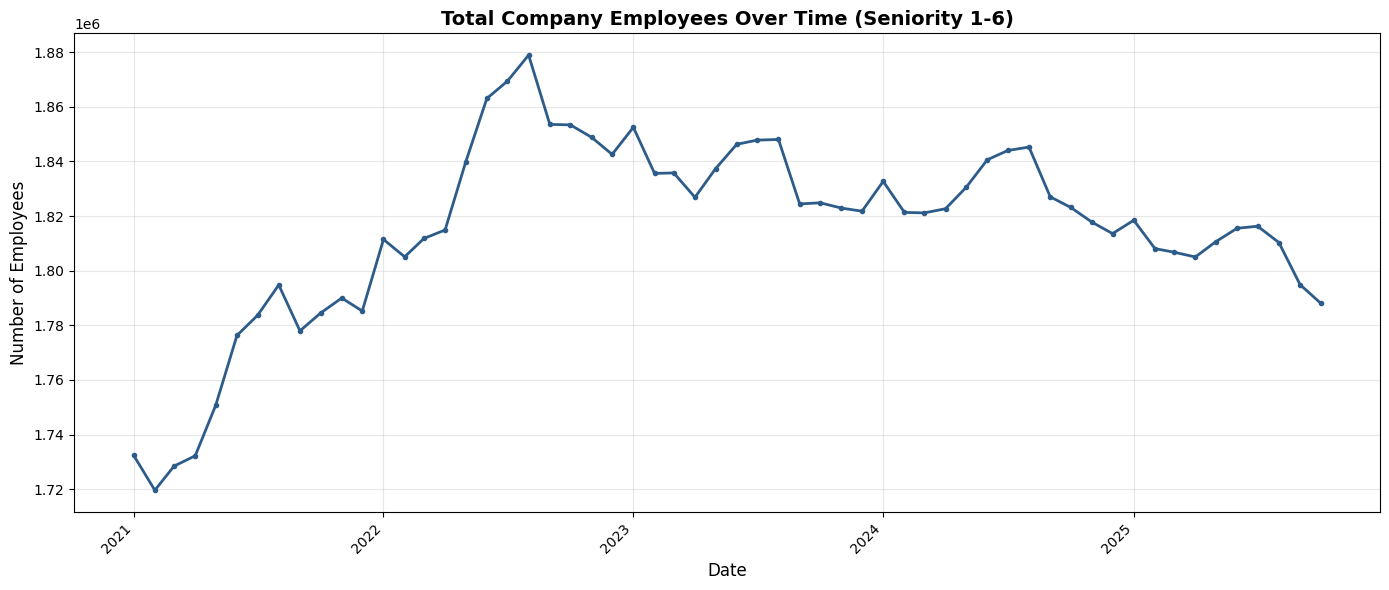


Summary Statistics:
Peak employment: 1,878,966.0 employees in August 2022
Starting employment (Jan 2021): 1,732,412.0 employees
Current employment (Oct 2025): 1,788,137.0 employees


,month,total_employees
0,2021-01-01,1732412.0
1,2021-02-01,1719622.0
2,2021-03-01,1728438.0
3,2021-04-01,1732242.0
4,2021-05-01,1750778.0
5,2021-06-01,1776317.0
6,2021-07-01,1783655.0
7,2021-08-01,1794791.0
8,2021-09-01,1777979.0
9,2021-10-01,1784479.0


In [9]:
# Total headcount across all firms, seniority levels, and quintiles
monthly_total = (
    panel_all
    .groupby('month', as_index=False)['employment']
    .sum()
    .rename(columns={'employment': 'total_employees'})
)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(monthly_total['month'], monthly_total['total_employees'],
        linewidth=2, color='#2E5C8A', marker='o', markersize=3)

ax.set_title('Total Company Employees Over Time (Seniority 1-6)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Employees', fontsize=12)
ax.grid(True, alpha=0.3)

# Format x-axis
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

print(f"\nSummary Statistics:")
print(f"Peak employment: {monthly_total['total_employees'].max():,} employees in {monthly_total.loc[monthly_total['total_employees'].idxmax(), 'month'].strftime('%B %Y')}")

# Jan 2021
jan_2021 = monthly_total.loc[monthly_total['month'] == pd.Timestamp('2021-01-01'), 'total_employees']
if not jan_2021.empty:
    print(f"Starting employment (Jan 2021): {jan_2021.iloc[0]:,} employees")

# Oct 2025
oct_2025 = monthly_total.loc[monthly_total['month'] == pd.Timestamp('2025-10-01'), 'total_employees']
if not oct_2025.empty:
    print(f"Current employment (Oct 2025): {oct_2025.iloc[0]:,} employees")

monthly_total

## 6. Visualize Total Employment Trends

**Objective**: Plot aggregate employment across all 30 Dow Jones firms over time.

**Aggregation**: Sum across all firms, seniority levels, and AI exposure quintiles by month.

**Interpretation**: Shows overall labor market trends - helps contextualize whether observed patterns are driven by general hiring/firing or AI-specific dynamics.

In [10]:
# Define seniority labels (consistent across notebook)
seniority_labels = {
    1: 'Early Career 1',
    2: 'Early Career 2',
    3: 'Developing',
    4: 'Mid-Career 1',
    5: 'Mid-Career 2',
    6: 'Senior'
}

# Baseline month for normalization
baseline_date = pd.Timestamp('2022-10-01')

# Create normalized series directly from panel_all
normalized_df = panel_all.copy()

# Get baseline employment for each seniority × quintile group
baseline_mask = normalized_df['month'] == baseline_date

baseline_by_group = (
    normalized_df[baseline_mask]
    .groupby(['seniority', 'quintile'])['employment']
    .sum()  # Sum across all firms
    .rename('baseline_emp')
)

# Aggregate employment by seniority × quintile × month (sum across firms)
agg_df = (
    normalized_df
    .groupby(['seniority', 'quintile', 'month'], as_index=False)['employment']
    .sum()
)

# Merge baseline values
agg_df = agg_df.merge(
    baseline_by_group,
    on=['seniority', 'quintile'],
    how='left'
)

# Calculate normalized headcount
agg_df['normalized_headcount'] = np.where(
    agg_df['baseline_emp'] > 0,
    agg_df['employment'] / agg_df['baseline_emp'],
    np.nan
)

print(f"Normalized data prepared for plotting")
print(f"Total data points: {len(agg_df)}")
agg_df.head()

Normalized data prepared for plotting
Total data points: 1740


,seniority,quintile,month,employment,baseline_emp,normalized_headcount
0,1,1,2021-01-01,64973.0,60838.0,1.067967
1,1,1,2021-02-01,64207.0,60838.0,1.055377
2,1,1,2021-03-01,64634.0,60838.0,1.062395
3,1,1,2021-04-01,64725.0,60838.0,1.063891
4,1,1,2021-05-01,65516.0,60838.0,1.076893


## 7. Normalize Employment by Seniority and Quintile

**Objective**: Calculate normalized headcount (relative to October 2022 baseline) for each seniority × quintile group.

**Normalization**:
- Baseline: October 2022 = 1.0 (month before ChatGPT release)
- Formula: `normalized = employment_t / employment_Oct2022`

**Purpose**: Enables comparison across groups with different absolute sizes - a decline from 1.0 to 0.9 represents 10% employment loss regardless of starting level.

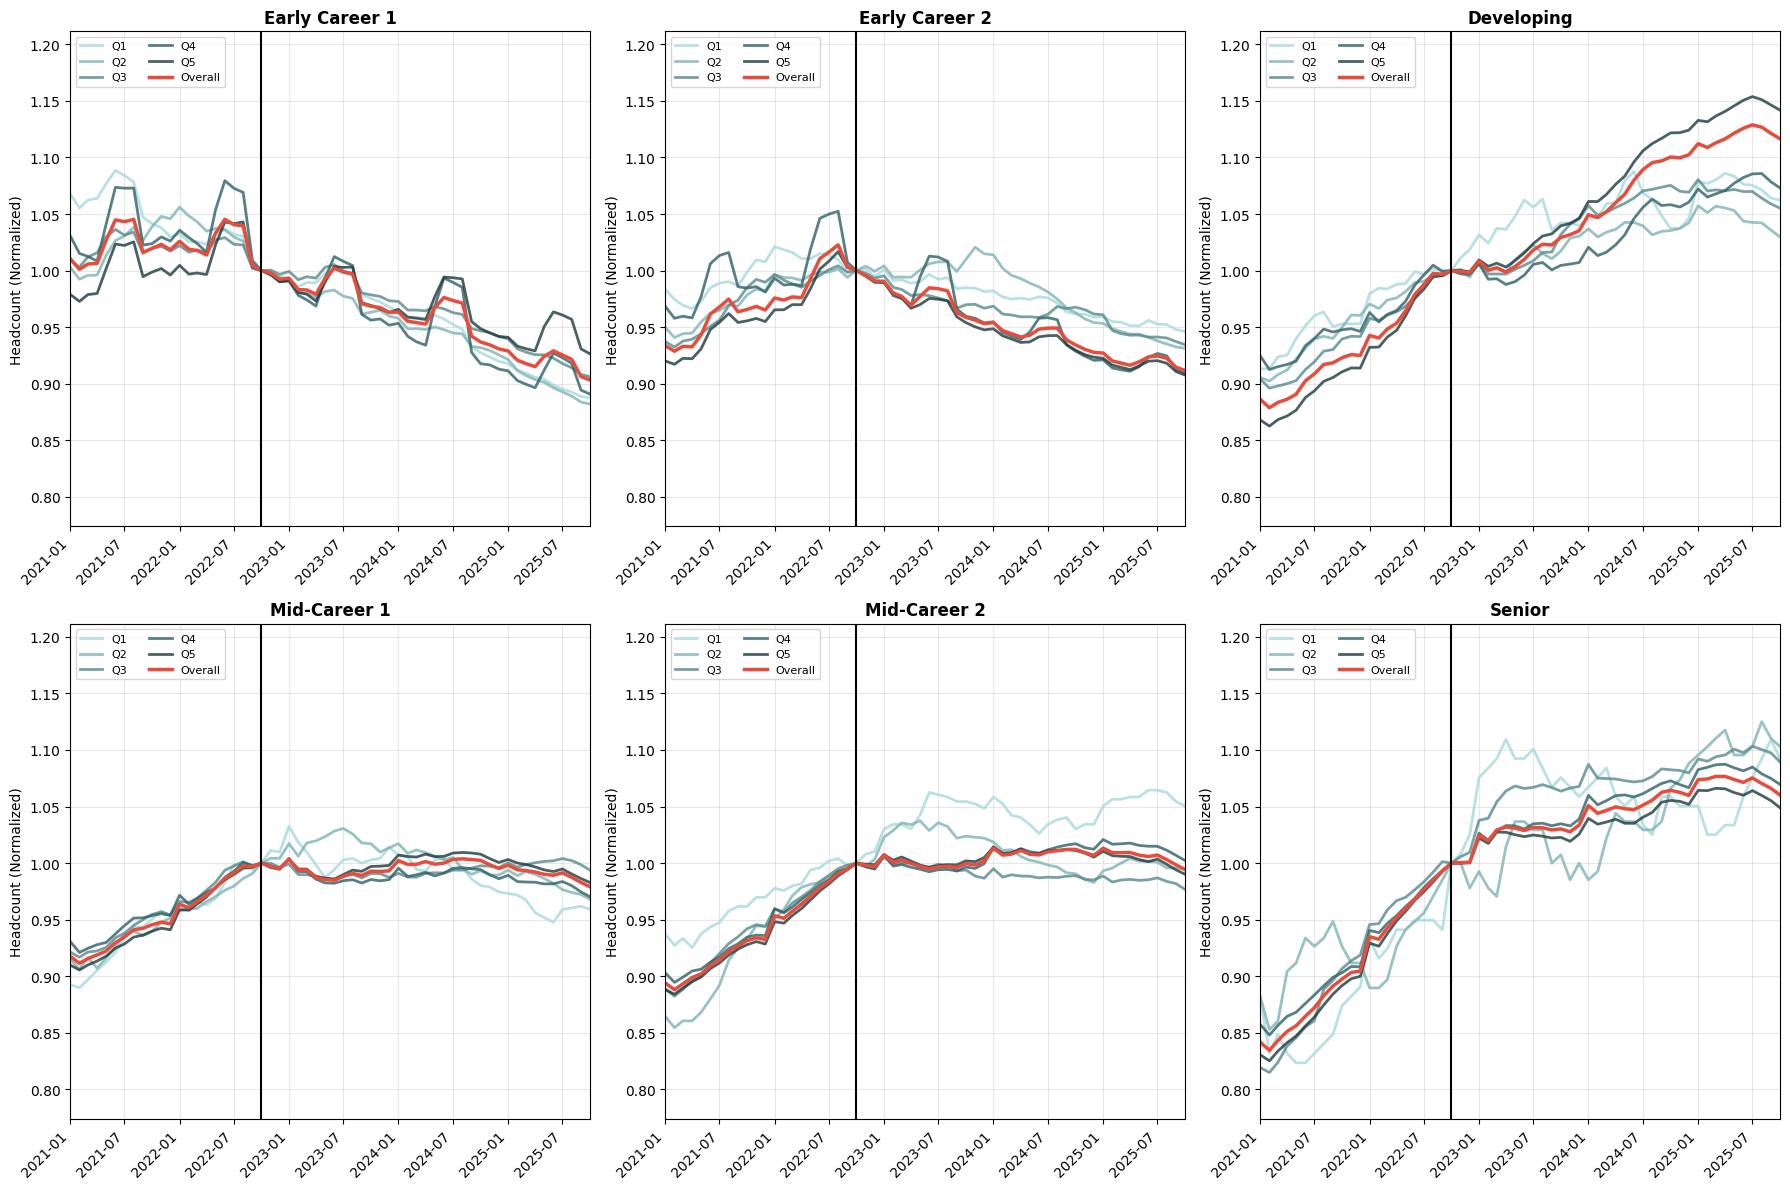

6-subplot figure completed - showing normalized employment by seniority and AI exposure


In [11]:
# Create 6 subplots (2 rows x 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Colors for quintiles - gradient from light to dark
colors = {
    1: '#A8DADC',  # Light blue (less exposed)
    2: '#80B3B5',
    3: '#578A8D',
    4: '#2E6166',
    5: '#1D3A3D'   # Dark blue (more exposed)
}

# Track all values for consistent y-axis
all_values = []

for idx, seniority in enumerate(range(1, 7)):
    ax = axes[idx]
    
    # Get label for this seniority level
    title = seniority_labels[seniority]
    
    # Filter data for this seniority
    sdata = agg_df[agg_df['seniority'] == seniority]
    
    # Plot all 5 quintiles
    for quintile in [1, 2, 3, 4, 5]:
        qdata = (
            sdata[sdata['quintile'] == quintile]
            .sort_values('month')
        )
        
        if not qdata.empty and qdata['normalized_headcount'].notna().any():
            ax.plot(
                qdata['month'],
                qdata['normalized_headcount'],
                color=colors[quintile],
                linewidth=2,
                label=f'Q{quintile}',
                alpha=0.8
            )
            all_values.extend(qdata['normalized_headcount'].dropna().tolist())
    
    # Calculate and plot overall for this seniority (sum across all quintiles)
    overall = (
        panel_all[panel_all['seniority'] == seniority]
        .groupby('month', as_index=False)['employment']
        .sum()
    )
    
    base_overall = overall.loc[overall['month'] == baseline_date, 'employment']
    if not base_overall.empty and base_overall.iloc[0] > 0:
        overall['normalized'] = overall['employment'] / base_overall.iloc[0]
        ax.plot(
            overall['month'],
            overall['normalized'],
            color='#E74C3C',
            linewidth=2.5,
            label='Overall'
        )
        all_values.extend(overall['normalized'].tolist())
    
    # Add vertical line at October 2022
    ax.axvline(x=baseline_date, color='black', linestyle='-', linewidth=1.5)
    
    # Formatting
    ax.set_title(title, fontsize=12, fontweight='bold')
    #ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Headcount (Normalized)', fontsize=10)
    ax.legend(loc='upper left', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Set x-axis limits to Jan 2021 - Oct 2025
    ax.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2025-10-01'))
    
    # Rotate x-axis labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Calculate dynamic y-axis limits based on all plotted values
if all_values:
    y_min = min(all_values) * 0.95  # 5% margin below minimum
    y_max = max(all_values) * 1.05  # 5% margin above maximum
    
    # Apply same y-axis limits to all subplots
    for idx in range(6):
        axes[idx].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

print("6-subplot figure completed - showing normalized employment by seniority and AI exposure")

## 8. Multi-Exposure Score Analysis: Generate All Enabled Plots

**Objective**: Generate comparison plots for all enabled exposure scores in a single automated workflow.

**Process**:
1. **Load company data once** (shared across all plots)
2. **For each enabled exposure score**:
   - Merge with appropriate exposure data
   - Create quintiles based on full exposure dataset
   - Generate normalized employment plots by seniority
3. **Output**: One 6-subplot figure per enabled exposure score

**Configuration**: Control which plots to generate in the configuration cell at the top of this notebook.

In [12]:
# ============================================================================
# FUNCTION: Process data for a specific exposure variable
# ============================================================================

def process_exposure_data(company_df_raw, exposure_info, exposure_key):
    """
    Process company data with a specific exposure score.
    Uses vectorized event-based approach (same as legacy workflow above).
    
    Parameters:
    -----------
    company_df_raw : DataFrame
        Raw company employment data
    exposure_info : dict
        Dictionary containing 'df', 'column', and 'title' for the exposure data
    exposure_key : str
        Key identifier for this exposure variable
        
    Returns:
    --------
    tuple: (company_df_clean, panel_all, quintile_mapping)
    """
    
    print("\n" + "="*80)
    print(f"PROCESSING: {exposure_info['title']}")
    print("="*80)
    
    # Get exposure dataframe and column name
    exposure_df = exposure_info['df']
    exposure_col = exposure_info['column']
    
    # Create mapping from O*NET code to exposure score
    exposure_mapping = exposure_df.set_index('O*NET-SOC Code')[exposure_col].to_dict()
    
    # Map exposure scores to company data
    company_df = company_df_raw.copy()
    company_df['dv_rating'] = company_df['onet_code'].map(exposure_mapping)
    
    # Check for missing codes
    missing_count = company_df['dv_rating'].isna().sum()
    print(f"Missing dv_rating: {missing_count} ({missing_count / len(company_df) * 100:.2f}%)")
    
    # Drop rows with missing codes
    company_df_clean = company_df.dropna(subset=['dv_rating'])
    print(f"Rows after cleaning: {len(company_df_clean):,}")
    
    # ============================================================================
    # CREATE QUINTILES FROM FULL EXPOSURE DATASET
    # ============================================================================
    
    elondou_occupations = exposure_df[['O*NET-SOC Code', exposure_col]].dropna().copy()
    elondou_occupations = elondou_occupations.rename(columns={
        'O*NET-SOC Code': 'onet_code',
        exposure_col: 'dv_rating'
    })
    elondou_occupations = elondou_occupations.drop_duplicates('onet_code')
    
    # Create quintiles (handle edge case where fewer than 5 bins are possible)
    try:
        elondou_occupations['occupation_quintile'] = pd.qcut(
            elondou_occupations['dv_rating'],
            q=5,
            labels=[1, 2, 3, 4, 5],
            duplicates='drop'
        )
    except ValueError:
        # If we can't create exactly 5 bins, let qcut determine the number
        elondou_occupations['occupation_quintile'] = pd.qcut(
            elondou_occupations['dv_rating'],
            q=5,
            labels=False,
            duplicates='drop'
        ) + 1  # +1 to make it 1-indexed
    
    # Map quintiles to company data
    quintile_mapping = elondou_occupations.set_index('onet_code')['occupation_quintile'].to_dict()
    company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)
    
    # Clean data
    company_df_clean = company_df_clean.dropna(subset=['quintile'])
    company_df_clean['quintile'] = company_df_clean['quintile'].astype(int)
    
    print(f"Employees with quintiles: {len(company_df_clean):,}")
    
    # ============================================================================
    # BUILD VECTORIZED MONTHLY PANEL (Same as legacy workflow)
    # ============================================================================
    
    df = company_df_clean.copy()
    
    # Merge seniority 7 into 6
    df.loc[df['seniority'] == 7, 'seniority'] = 6
    
    # Convert to datetime
    df['startdate'] = pd.to_datetime(df['startdate'])
    df['enddate'] = pd.to_datetime(df['enddate'])
    
    # Define global month range
    first_month = pd.Timestamp('2021-01-01')
    last_month = pd.Timestamp('2025-10-01')
    months = pd.date_range(start=first_month, end=last_month, freq='MS')
    
    # Map each calendar month to an integer index
    month_to_idx = {m: i for i, m in enumerate(months)}
    idx_to_month = {i: m for m, i in month_to_idx.items()}
    
    # Map position spells to integer indices (convert to month start)
    df['start_m'] = df['startdate'].dt.to_period('M').dt.to_timestamp()
    df['end_m'] = df['enddate'].dt.to_period('M').dt.to_timestamp()
    
    # Drop spells that never overlap the analysis window
    df['end_m_temp'] = df['end_m'].fillna(pd.Timestamp('2099-01-01'))
    overlap_mask = (df['end_m_temp'] >= first_month) & (df['start_m'] <= last_month)
    df = df[overlap_mask].drop(columns='end_m_temp').copy()
    
    # Clamp to the window
    df['start_m'] = df['start_m'].clip(lower=first_month, upper=last_month)
    df['end_m'] = df['end_m'].fillna(last_month).clip(lower=first_month, upper=last_month)
    
    # Month indices
    df['start_idx'] = df['start_m'].map(month_to_idx)
    df['end_idx'] = df['end_m'].map(month_to_idx)
    
    # Build events: +1 at start, -1 at end+1
    events_start = df[['rcid', 'seniority', 'quintile', 'start_idx']].copy()
    events_start = events_start.rename(columns={'start_idx': 'm_idx'})
    events_start['delta'] = 1
    
    events_end = df[['rcid', 'seniority', 'quintile', 'end_idx']].copy()
    events_end = events_end.rename(columns={'end_idx': 'm_idx'})
    events_end['m_idx'] = events_end['m_idx'] + 1  # one month after end
    events_end['delta'] = -1
    
    events = pd.concat([events_start, events_end], ignore_index=True)
    
    # Drop events beyond last index
    max_idx = len(months) - 1
    events = events[events['m_idx'] <= max_idx]
    
    # Aggregate deltas by group and month index
    events_agg = (
        events
        .groupby(['rcid', 'seniority', 'quintile', 'm_idx'], as_index=False)['delta']
        .sum()
    )
    
    # Create full grid of rcid × seniority × quintile × m_idx
    keys = events_agg[['rcid', 'seniority', 'quintile']].drop_duplicates()
    full_grid = (
        keys.assign(key=1)
        .merge(
            pd.DataFrame({'m_idx': np.arange(len(months)), 'key': 1}),
            on='key',
            how='outer'
        )
        .drop(columns='key')
    )
    
    # Merge and fill missing deltas with zero, then cumulative sum
    panel_all = (
        full_grid
        .merge(events_agg, on=['rcid', 'seniority', 'quintile', 'm_idx'], how='left')
        .sort_values(['rcid', 'seniority', 'quintile', 'm_idx'])
    )
    
    panel_all['delta'] = panel_all['delta'].fillna(0)
    
    panel_all['employment'] = (
        panel_all
        .groupby(['rcid', 'seniority', 'quintile'])['delta']
        .cumsum()
    )
    
    # Add calendar month
    panel_all['month'] = panel_all['m_idx'].map(idx_to_month)
    
    print(f"Panel data created: {len(panel_all):,} rows")
    
    return company_df_clean, panel_all, quintile_mapping

In [ ]:
# ============================================================================
# FUNCTION: Generate 6-subplot figure for an exposure score
# ============================================================================

def plot_exposure_comparison(panel_all, exposure_title, exposure_key):
    """
    Create 6-subplot figure showing normalized employment by seniority and quintile.
    
    Parameters:
    -----------
    panel_all : DataFrame
        Panel data with columns: month, seniority, quintile, employment, company_name
    exposure_title : str
        Title for this exposure measure (displayed in figure title)
    exposure_key : str
        Key identifier for filename
    """
    
    # Seniority labels
    seniority_labels = {
        1: 'Early Career 1',
        2: 'Early Career 2',
        3: 'Developing',
        4: 'Mid-Career 1',
        5: 'Mid-Career 2',
        6: 'Senior'
    }
    
    # Baseline month for normalization
    baseline_date = pd.Timestamp('2022-10-01')
    
    # Create normalized series
    normalized_df = panel_all.copy()
    
    # Get baseline employment for each seniority × quintile group
    baseline_mask = normalized_df['month'] == baseline_date
    baseline_by_group = (
        normalized_df[baseline_mask]
        .groupby(['seniority', 'quintile'])['employment']
        .sum()
        .rename('baseline_emp')
    )
    
    # Aggregate employment by seniority × quintile × month
    agg_df = (
        normalized_df
        .groupby(['seniority', 'quintile', 'month'], as_index=False)['employment']
        .sum()
    )
    
    # Merge baseline values
    agg_df = agg_df.merge(baseline_by_group, on=['seniority', 'quintile'], how='left')
    
    # Calculate normalized headcount
    agg_df['normalized_headcount'] = np.where(
        agg_df['baseline_emp'] > 0,
        agg_df['employment'] / agg_df['baseline_emp'],
        np.nan
    )
    
    # ============================================================================
    # CREATE FIGURE
    # ============================================================================
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Add main title
    # fig.suptitle(f'Employment Trends by AI Exposure: {exposure_title}', 
    #              fontsize=16, fontweight='bold', y=0.995)
    
    # Colors for quintiles
    colors = {
        1: '#A8DADC',  # Light blue (less exposed)
        2: '#80B3B5',
        3: '#578A8D',
        4: '#2E6166',
        5: '#1D3A3D'   # Dark blue (more exposed)
    }
    
    # Track all values for consistent y-axis
    all_values = []
    
    for idx, seniority in enumerate(range(1, 7)):
        ax = axes[idx]
        
        # Get label for this seniority level
        title = seniority_labels[seniority]
        
        # Filter data for this seniority
        sdata = agg_df[agg_df['seniority'] == seniority]
        
        # Plot all 5 quintiles
        for quintile in [1, 2, 3, 4, 5]:
            qdata = sdata[sdata['quintile'] == quintile].sort_values('month')
            
            if not qdata.empty and qdata['normalized_headcount'].notna().any():
                ax.plot(
                    qdata['month'],
                    qdata['normalized_headcount'],
                    color=colors[quintile],
                    linewidth=2,
                    label=f'Q{quintile}',
                    alpha=0.8
                )
                all_values.extend(qdata['normalized_headcount'].dropna().tolist())
        
        # Calculate and plot overall for this seniority
        overall = (
            panel_all[panel_all['seniority'] == seniority]
            .groupby('month', as_index=False)['employment']
            .sum()
        )
        
        base_overall = overall.loc[overall['month'] == baseline_date, 'employment']
        if not base_overall.empty and base_overall.iloc[0] > 0:
            overall['normalized'] = overall['employment'] / base_overall.iloc[0]
            ax.plot(
                overall['month'],
                overall['normalized'],
                color='#E74C3C',
                linewidth=2.5,
                label='Overall'
            )
            all_values.extend(overall['normalized'].tolist())
        
        # Add vertical line at October 2022
        ax.axvline(x=baseline_date, color='black', linestyle='-', linewidth=1.5)
        
        # Formatting
        ax.set_title(title, fontsize=12, fontweight='bold')
        #ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Headcount (Normalized)', fontsize=10)
        ax.legend(loc='upper left', fontsize=8, ncol=2)
        ax.grid(True, alpha=0.3)
        
        # Set x-axis limits
        ax.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2025-10-01'))
        
        # Rotate x-axis labels
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Calculate dynamic y-axis limits
    if all_values:
        y_min = min(all_values) * 0.95
        y_max = max(all_values) * 1.05
        
        for idx in range(6):
            axes[idx].set_ylim(y_min, y_max)
    
    # Save as PDF
    outdir = os.path.join(notebook_dir, "..","Results")
    os.makedirs(outdir, exist_ok=True)
    
    safe_key = "".join(ch if ch.isalnum() else "_" for ch in exposure_key).strip("_")
    outpath = os.path.join(outdir, f"{safe_key}.pdf")
    fig.savefig(outpath, format='pdf', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {outpath}")
    
    plt.show()
    print(f"✓ Plot generated for: {exposure_title}\n")

Loading company employment data...
✓ Loaded 4,315,587 employment records

GENERATING 10 PLOTS

[1/10] Processing: occ_dv_rating_alpha

PROCESSING: Elondou Rating Alpha
Missing dv_rating: 368628 (8.54%)
Rows after cleaning: 3,946,959


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 3,946,959
Panel data created: 52,200 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/occ_dv_rating_alpha.pdf


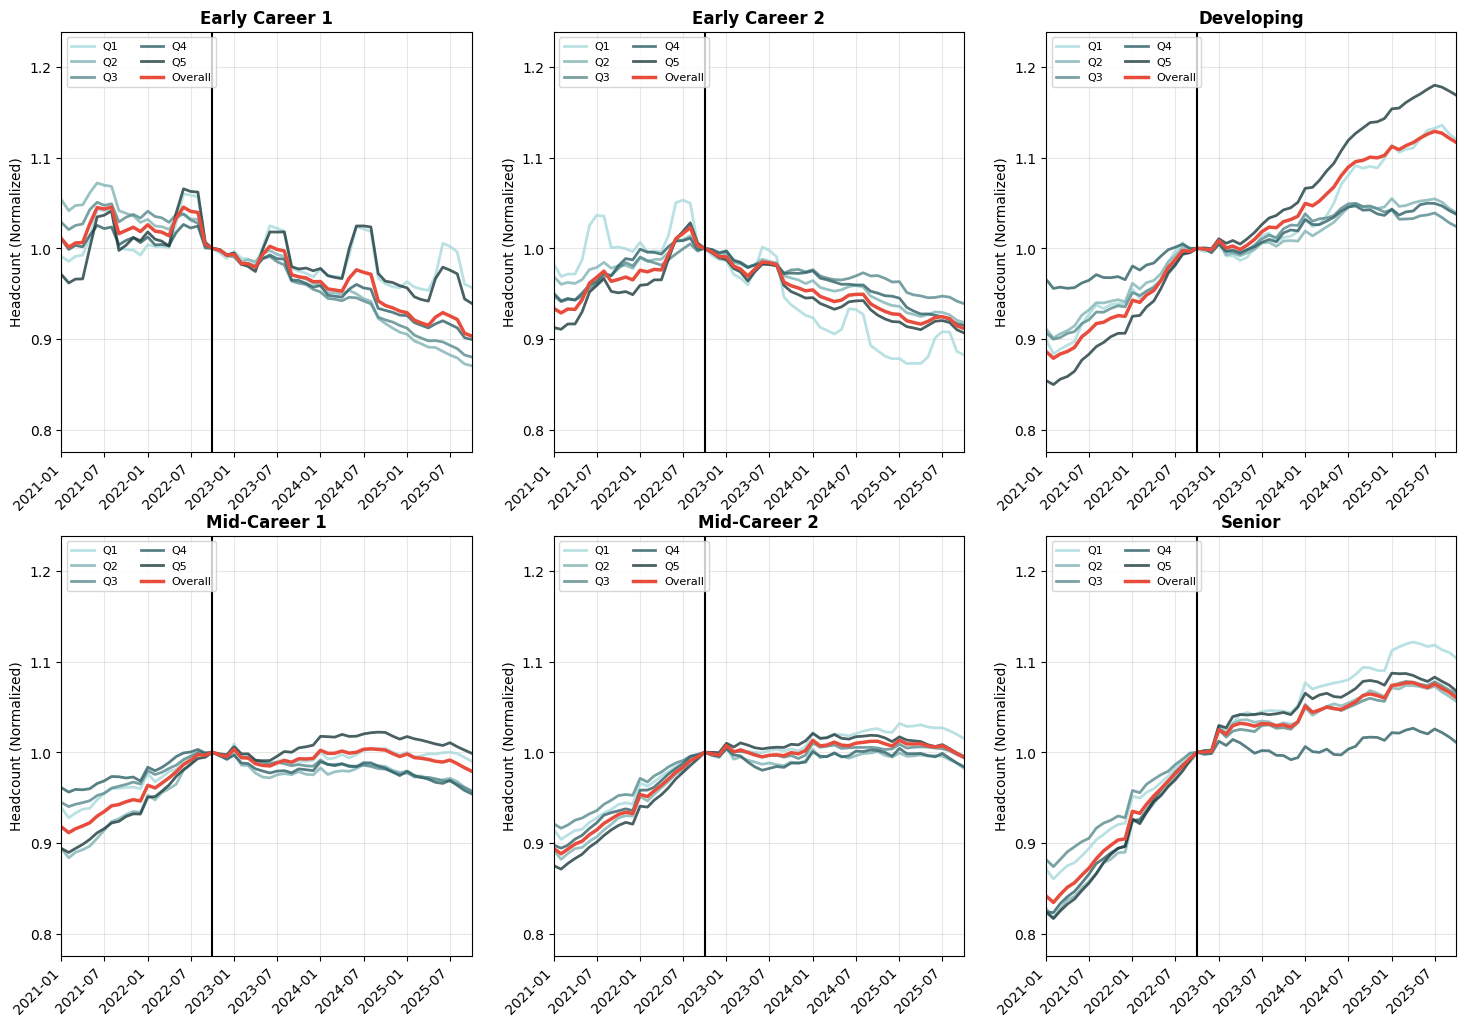

✓ Plot generated for: Elondou Rating Alpha


[2/10] Processing: occ_dv_rating_beta

PROCESSING: Elondou Rating Beta
Missing dv_rating: 368628 (8.54%)
Rows after cleaning: 3,946,959


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 3,946,959
Panel data created: 51,968 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/occ_dv_rating_beta.pdf


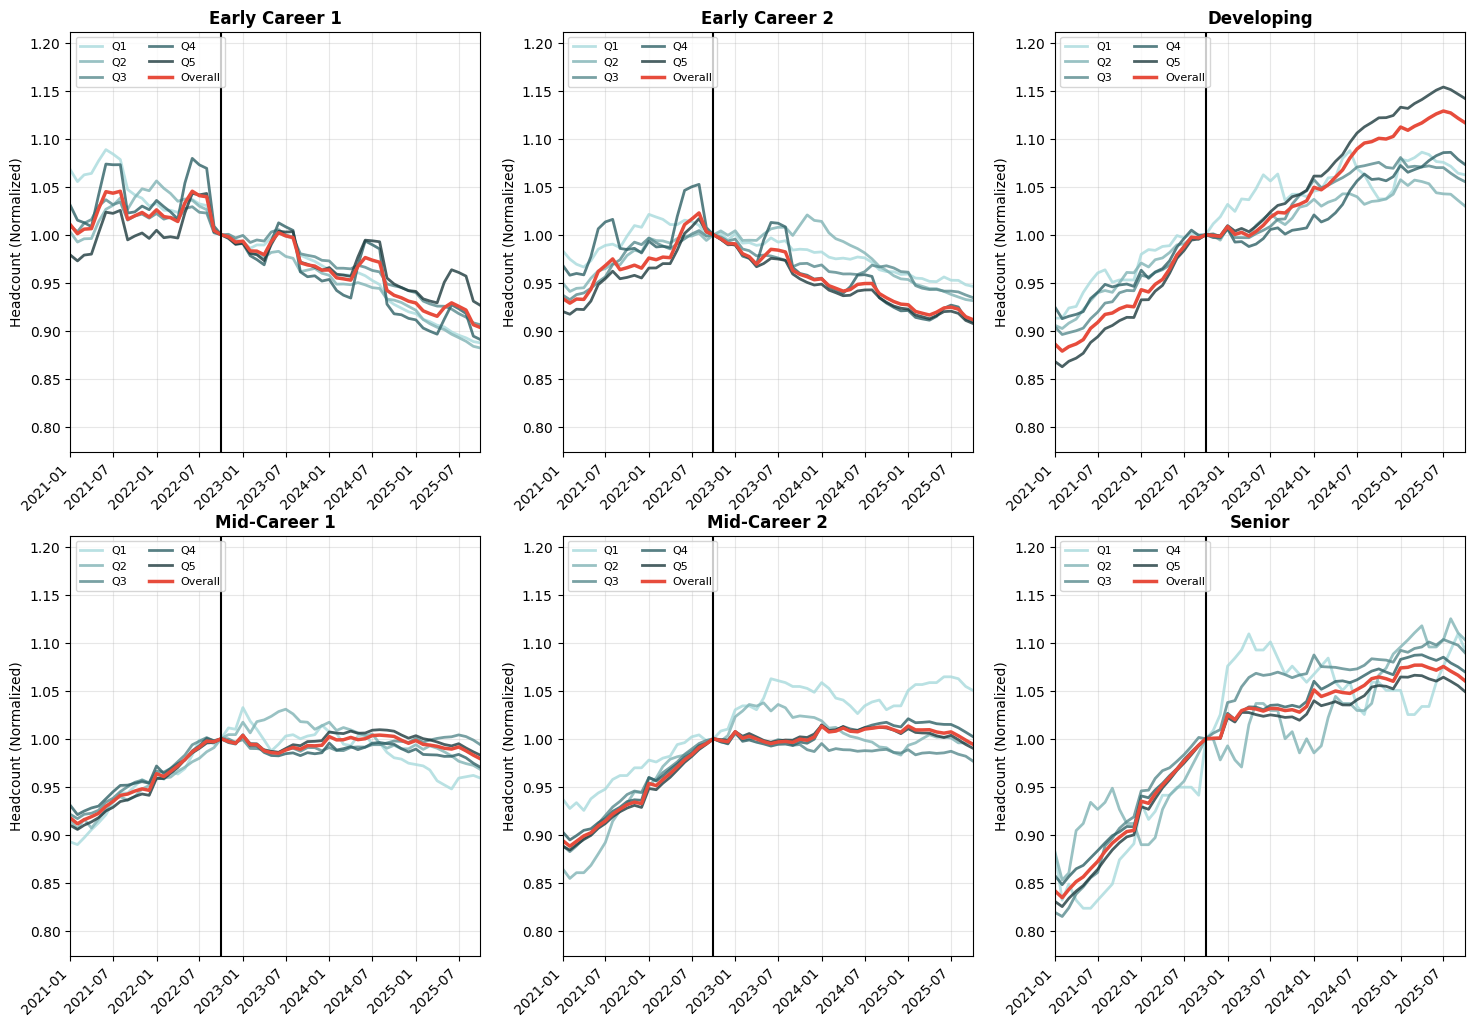

✓ Plot generated for: Elondou Rating Beta


[3/10] Processing: occ_dv_rating_gamma

PROCESSING: Elondou Rating Gamma
Missing dv_rating: 368628 (8.54%)
Rows after cleaning: 3,946,959


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 3,946,959
Panel data created: 51,968 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/occ_dv_rating_gamma.pdf


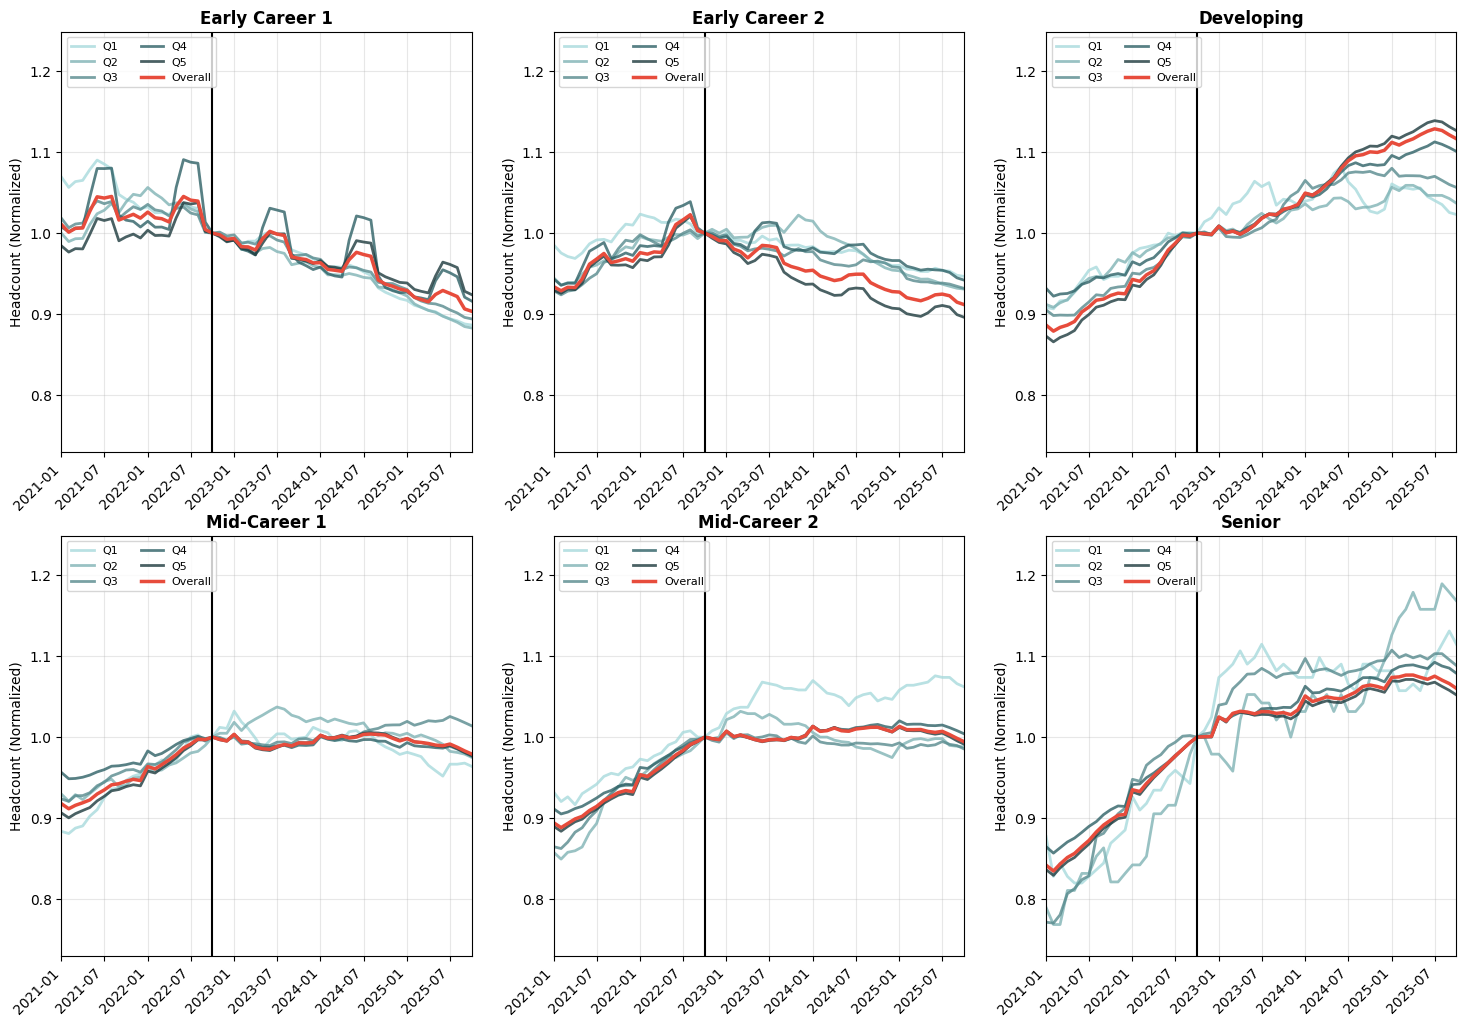

✓ Plot generated for: Elondou Rating Gamma


[4/10] Processing: occ_human_rating_alpha

PROCESSING: Elondou Human Rating Alpha
Missing dv_rating: 368628 (8.54%)
Rows after cleaning: 3,946,959


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 3,946,959
Panel data created: 41,760 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/occ_human_rating_alpha.pdf


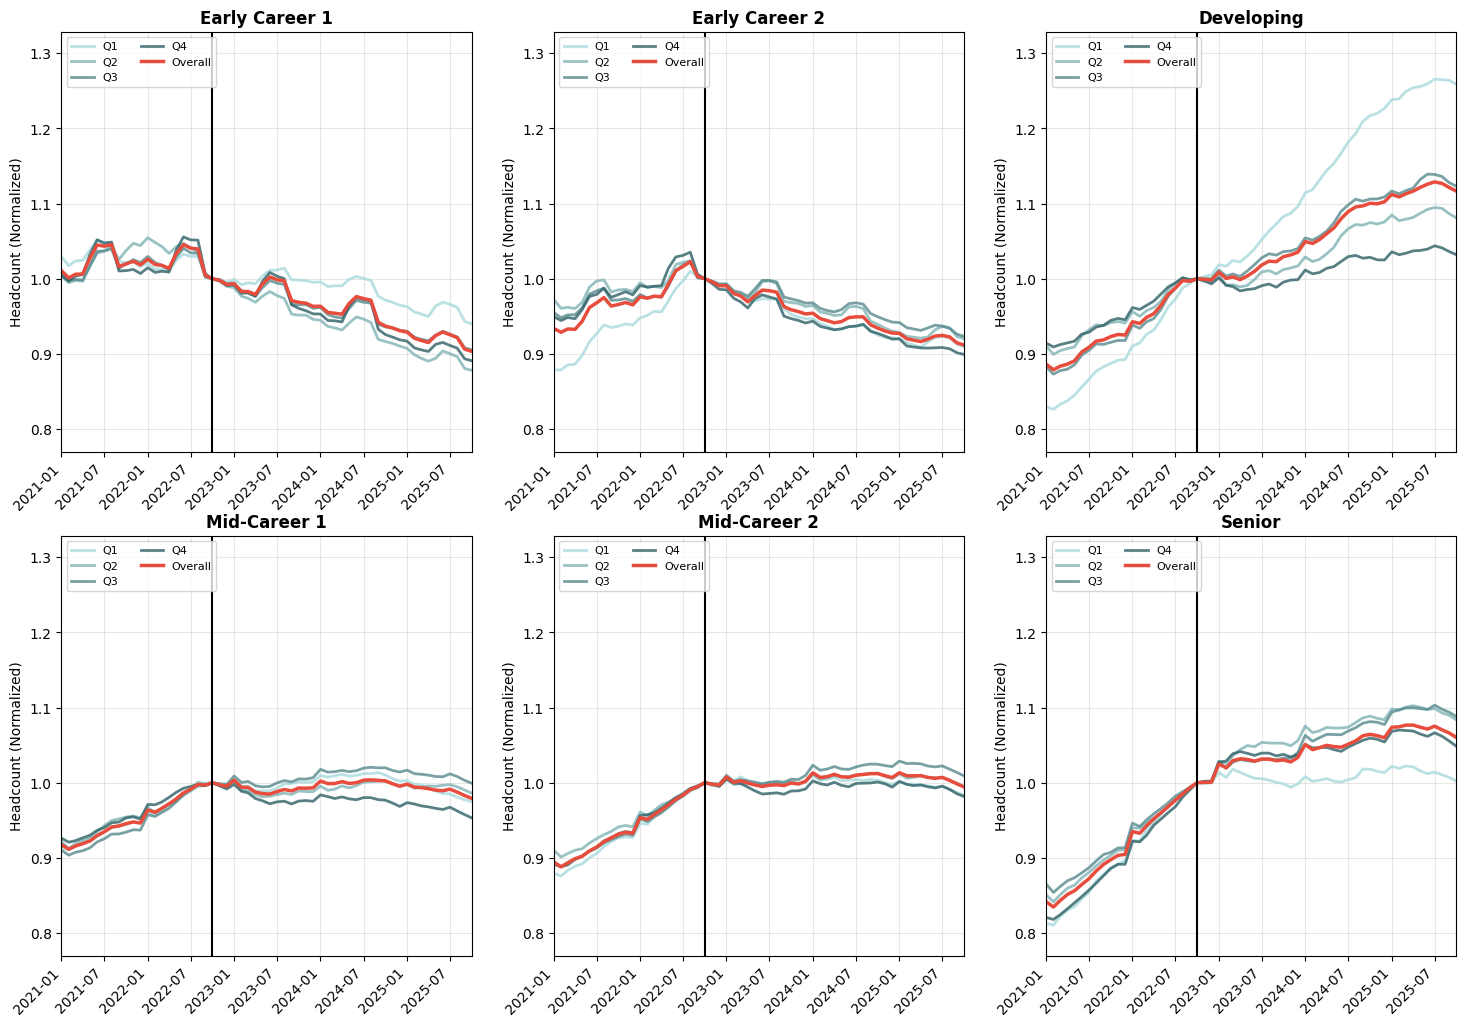

✓ Plot generated for: Elondou Human Rating Alpha


[5/10] Processing: occ_human_rating_beta

PROCESSING: Elondou Human Rating Beta
Missing dv_rating: 368628 (8.54%)
Rows after cleaning: 3,946,959


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 3,946,959
Panel data created: 52,026 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/occ_human_rating_beta.pdf


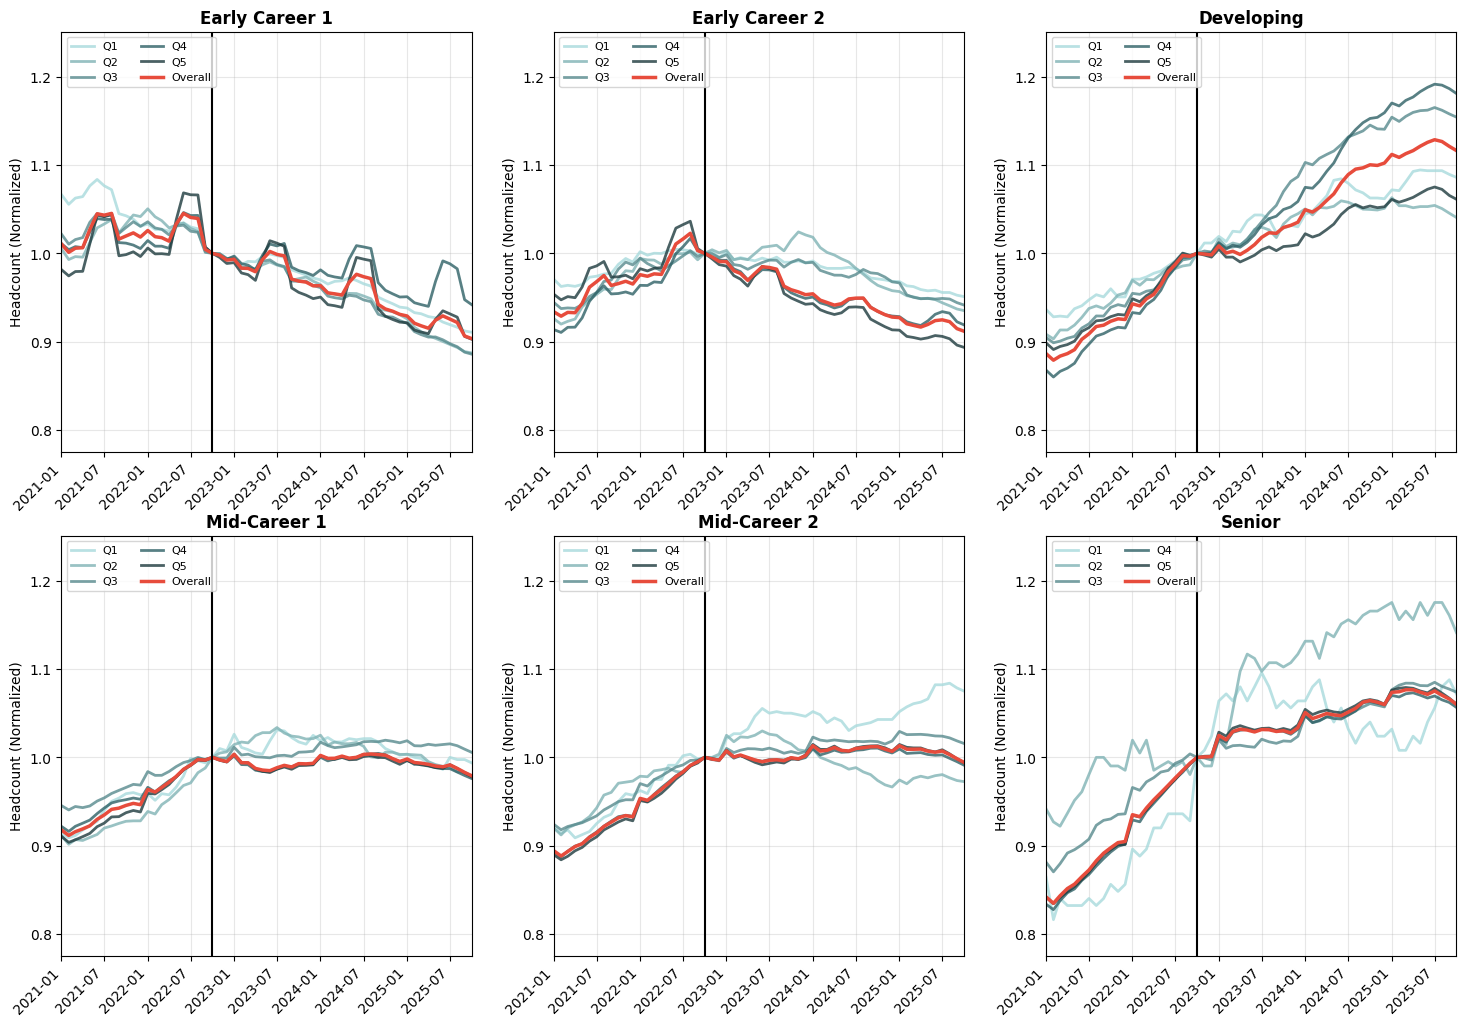

✓ Plot generated for: Elondou Human Rating Beta


[6/10] Processing: occ_human_rating_gamma

PROCESSING: Elondou Human Rating Gamma
Missing dv_rating: 368628 (8.54%)
Rows after cleaning: 3,946,959


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 3,946,959
Panel data created: 51,968 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/occ_human_rating_gamma.pdf


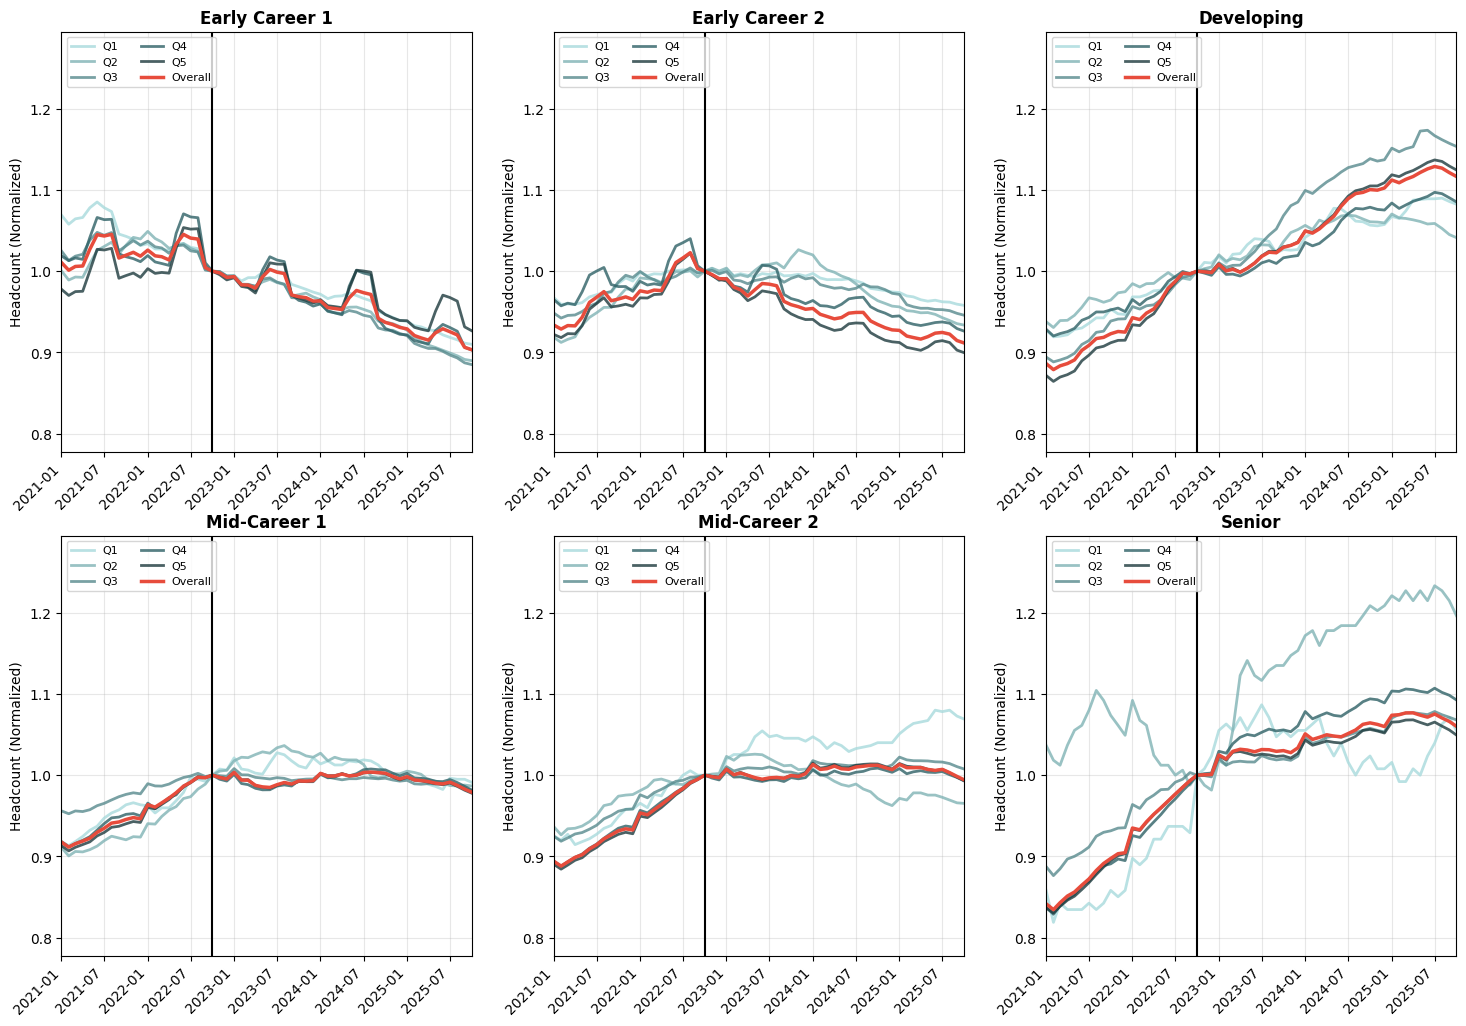

✓ Plot generated for: Elondou Human Rating Gamma


[7/10] Processing: pi_dv_rating_alpha

PROCESSING: π-weighted Rating Alpha
Missing dv_rating: 1911869 (44.30%)
Rows after cleaning: 2,403,718


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 2,403,718
Panel data created: 41,760 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/pi_dv_rating_alpha.pdf


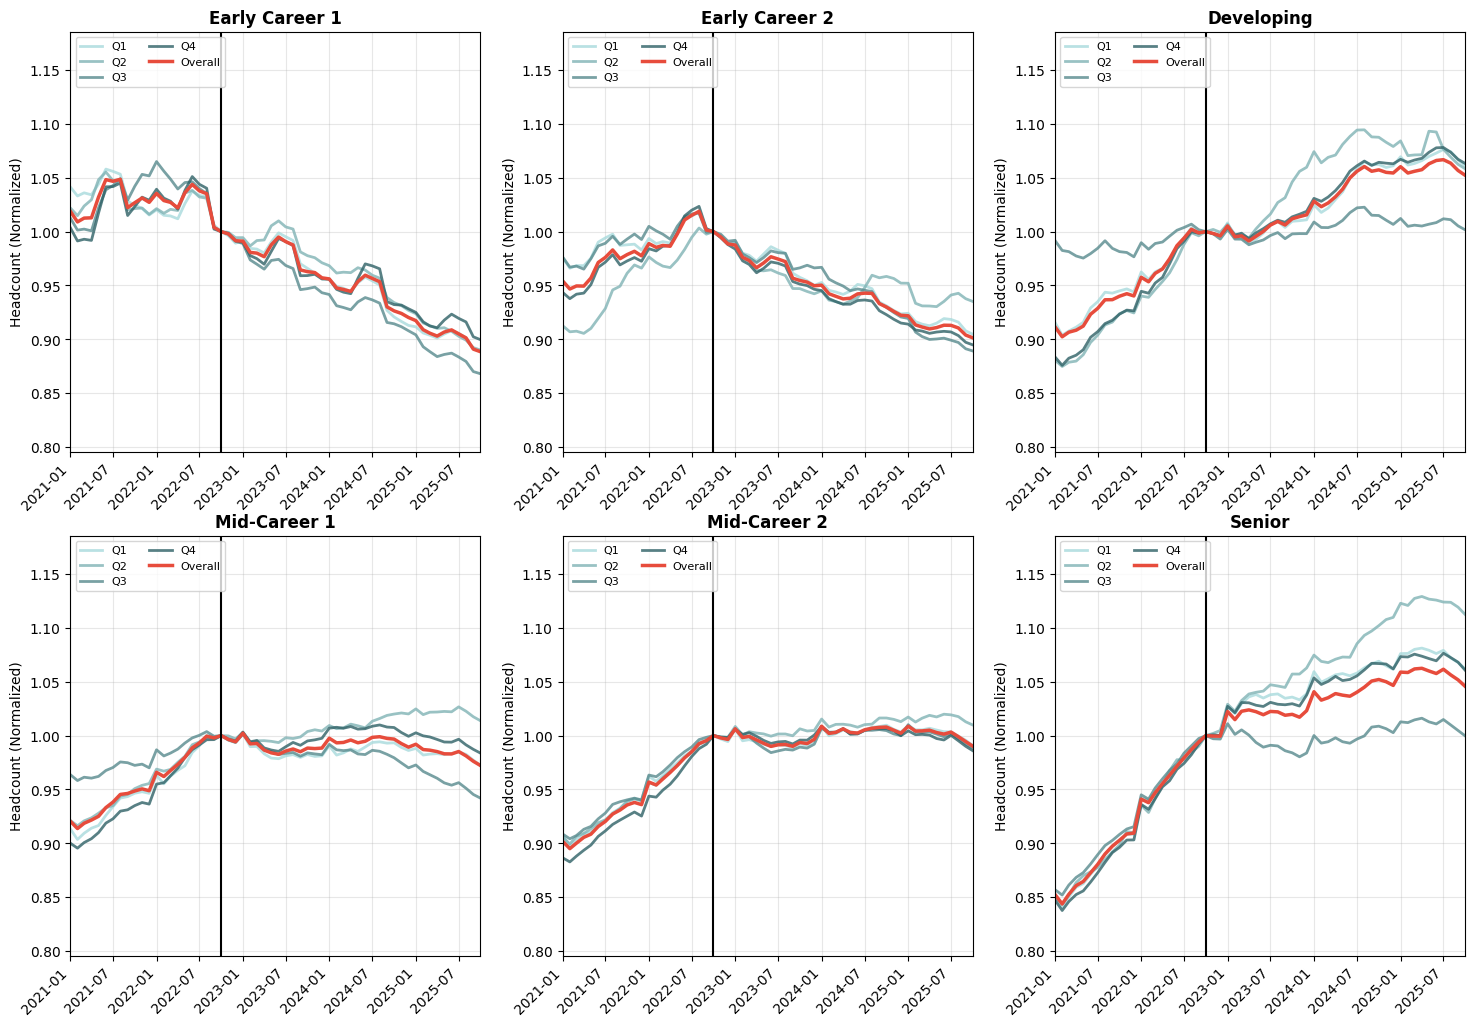

✓ Plot generated for: π-weighted Rating Alpha


[8/10] Processing: pi_dv_rating_beta

PROCESSING: π-weighted Rating Beta
Missing dv_rating: 1911869 (44.30%)
Rows after cleaning: 2,403,718


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 2,403,718
Panel data created: 51,852 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/pi_dv_rating_beta.pdf


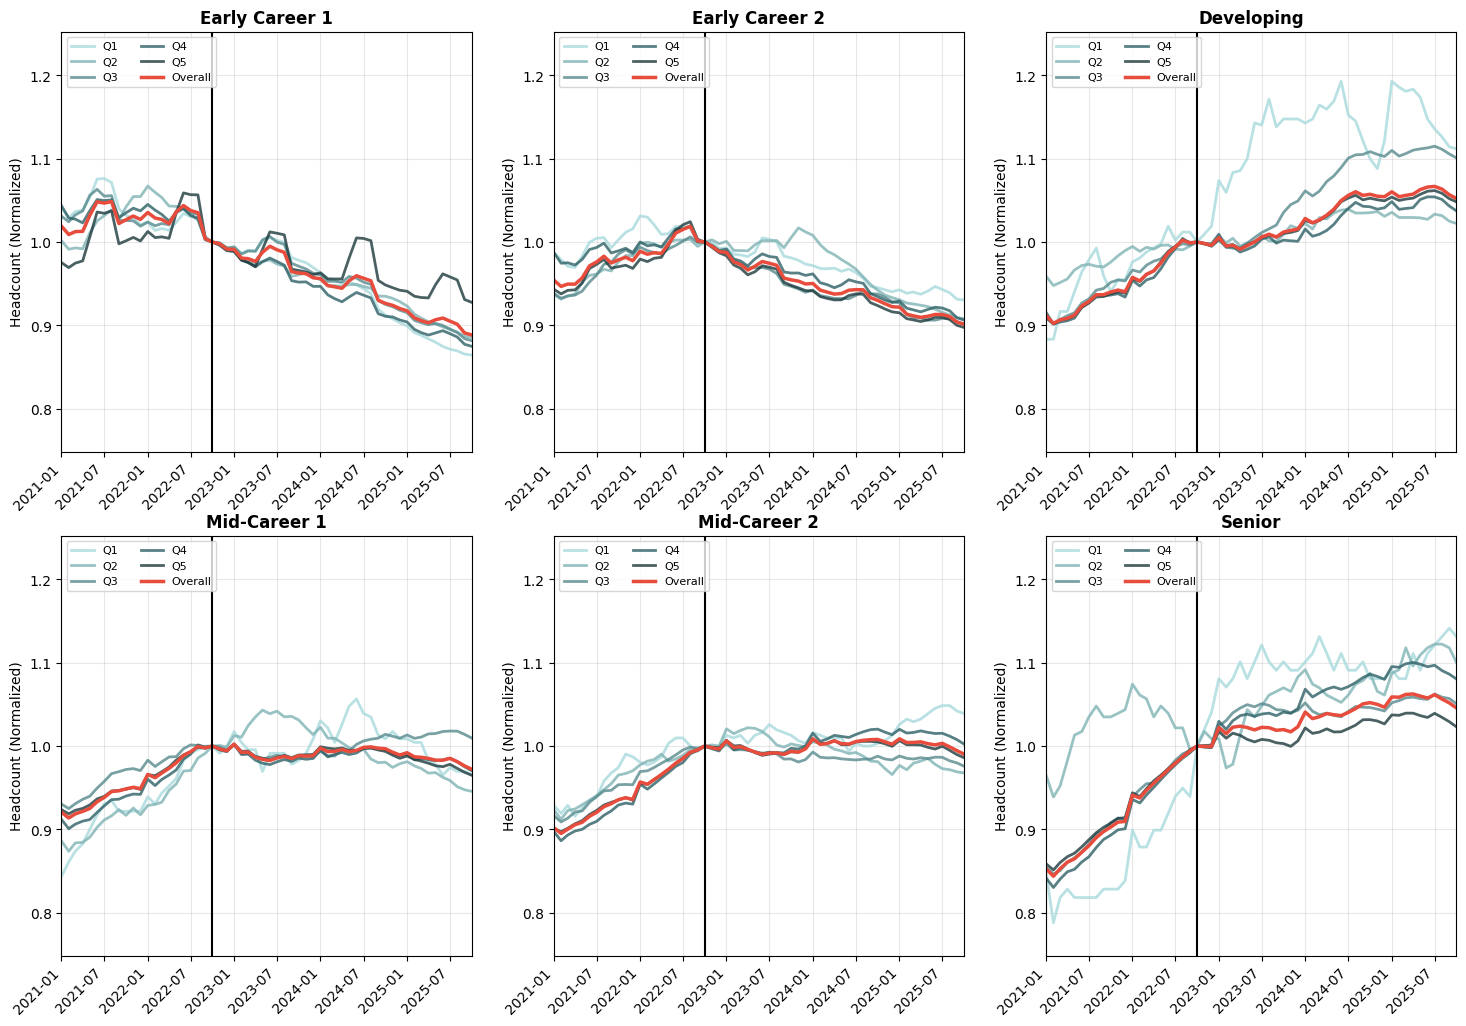

✓ Plot generated for: π-weighted Rating Beta


[9/10] Processing: pi_dv_rating_gamma

PROCESSING: π-weighted Rating Gamma
Missing dv_rating: 1911869 (44.30%)
Rows after cleaning: 2,403,718


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 2,403,718
Panel data created: 51,852 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/pi_dv_rating_gamma.pdf


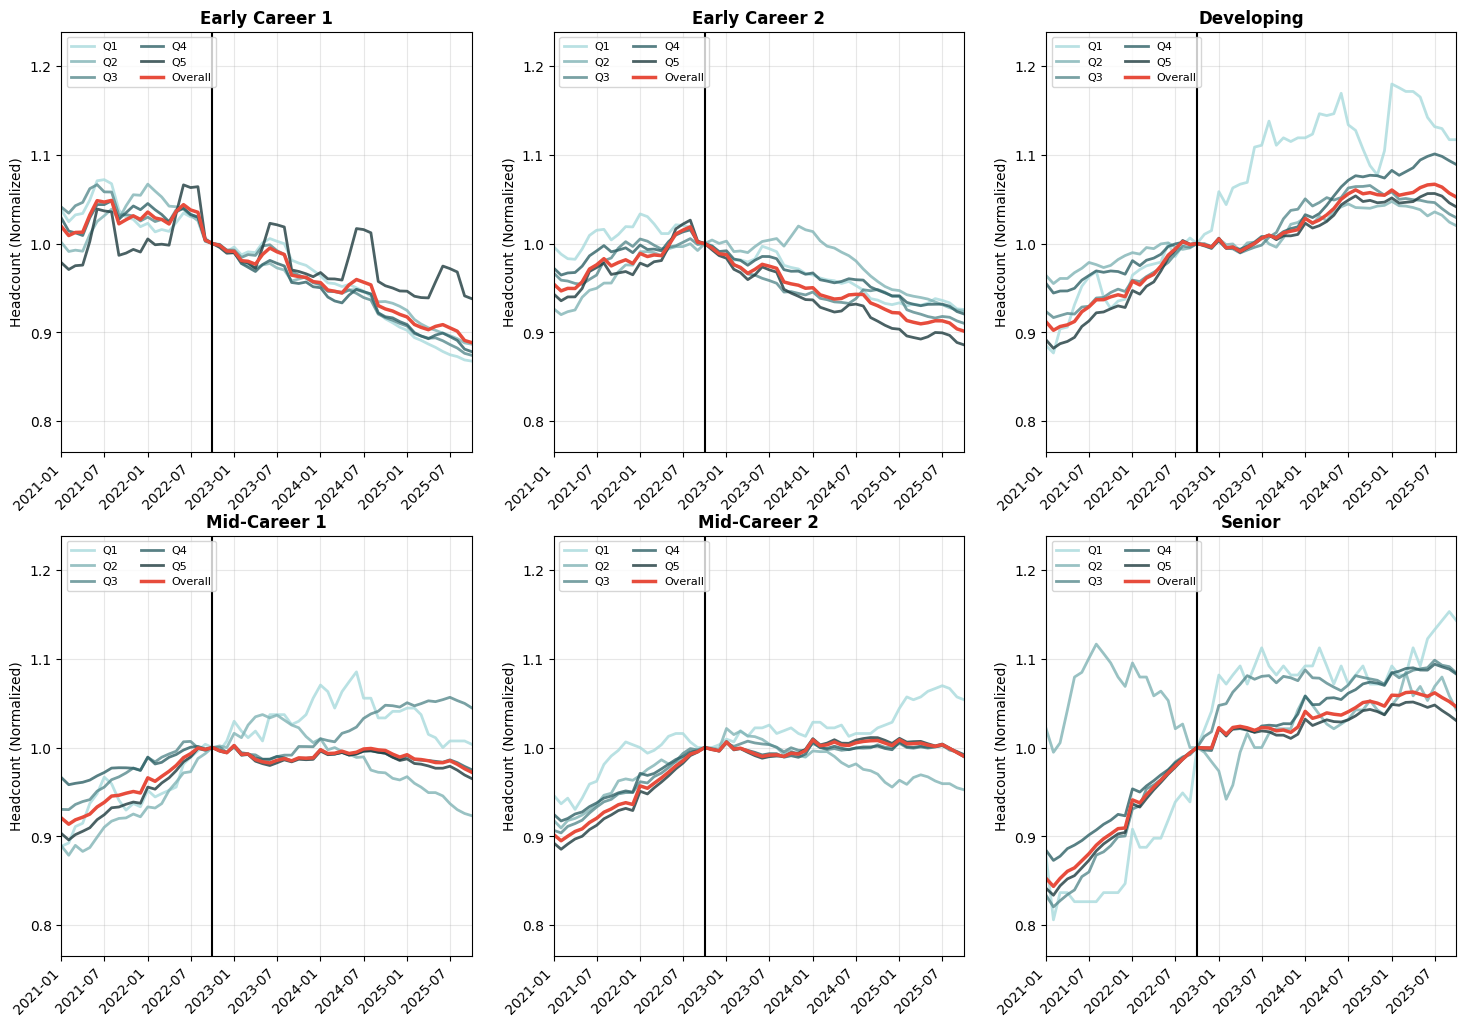

✓ Plot generated for: π-weighted Rating Gamma


[10/10] Processing: pierre_dv_rating

PROCESSING: π-weighted Sentiment Rating
Missing dv_rating: 931391 (21.58%)
Rows after cleaning: 3,384,196


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 3,384,196
Panel data created: 52,200 rows
✓ Saved: /Users/nicobagnoli/Documents/PYTHON/REVELIO_LABS_DATA_NEW/Thesis/Part 1/images/pierre_dv_rating.pdf


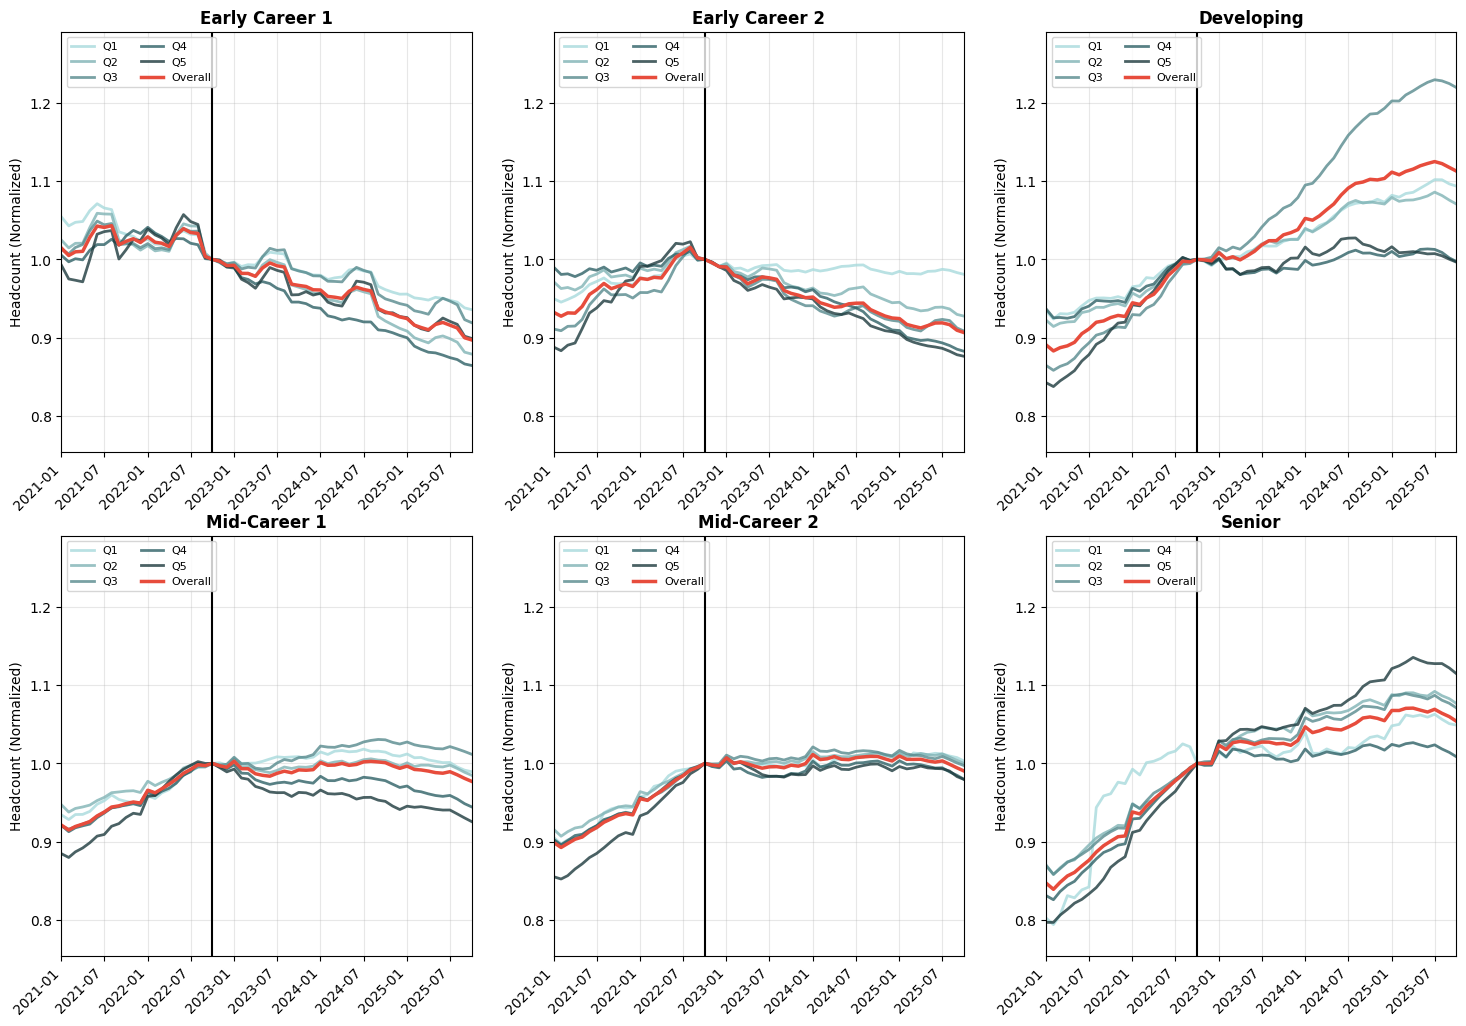

✓ Plot generated for: π-weighted Sentiment Rating


ALL PLOTS COMPLETED!
Total plots generated: 10
Disabled plots: 0


In [ ]:
# ============================================================================
# MAIN EXECUTION: Generate all enabled plots
# ============================================================================

# Load company data once (shared across all plots)
print("Loading company employment data...")
company_df_raw = pd.read_parquet(os.path.join(notebook_dir, "..","Data", "DOW.parquet"))
print(f"✓ Loaded {len(company_df_raw):,} employment records\n")

# Filter to only enabled plots
enabled_plots = {k: v for k, v in PLOT_CONFIG.items() if v}

print("="*80)
print(f"GENERATING {len(enabled_plots)} PLOTS")
print("="*80)

# Generate each enabled plot
for plot_idx, (exposure_key, is_enabled) in enumerate(enabled_plots.items(), 1):
    
    print(f"\n[{plot_idx}/{len(enabled_plots)}] Processing: {exposure_key}")
    
    # Get exposure info
    exposure_info = EXPOSURE_DATA[exposure_key]
    
    # Process data for this exposure variable
    company_df_clean, panel_all, quintile_mapping = process_exposure_data(
        company_df_raw, 
        exposure_info, 
        exposure_key
    )
    
    # Generate plot
    plot_exposure_comparison(panel_all, exposure_info['title'], exposure_key)

print("\n" + "="*80)
print("ALL PLOTS COMPLETED!")
print("="*80)
print(f"Total plots generated: {len(enabled_plots)}")
print(f"Disabled plots: {sum(not v for v in PLOT_CONFIG.values())}")

---

## ✅ Multi-Exposure Score Analysis Complete

This notebook now supports automated generation of comparison plots for **10 different exposure scores** across **3 datasets**:

### 📊 Available Exposure Scores

**From `occ_level.csv` (Elondou et al.)**:
- `dv_rating_alpha` - DV Rating Alpha
- `dv_rating_beta` - DV Rating Beta  
- `dv_rating_gamma` - DV Rating Gamma
- `human_rating_alpha` - Human Rating Alpha
- `human_rating_beta` - Human Rating Beta
- `human_rating_gamma` - Human Rating Gamma

**From `pi_occ_level.csv`**:
- `dv_rating_alpha` - PI DV Rating Alpha
- `dv_rating_beta` - PI DV Rating Beta
- `dv_rating_gamma` - PI DV Rating Gamma

**From `pierre_occ_level.csv`**:
- `dv_rating` - Pierre DV Rating

### 🎛️ How to Use

1. **Configure plots**: Scroll to the top configuration cell and set `True`/`False` for each plot
2. **Run all cells**: Execute the notebook from top to bottom
3. **View results**: Each enabled plot will be generated automatically

### 📈 Output Format

Each plot shows:
- **6 subplots** (one per career stage: Early Career 1/2, Developing, Mid-Career 1/2, Senior)
- **5 quintiles** (Q1-Q5) of AI exposure
- **Overall trend** (red line)
- **Normalized to Oct 2022** (baseline = 1.0)

---


PROCESSING: Elondou Rating Beta
Missing dv_rating: 368628 (8.54%)
Rows after cleaning: 3,946,959


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 3,946,959
Panel data created: 51,968 rows
Saved: images/early_career2_occ_dv_rating_beta.pdf


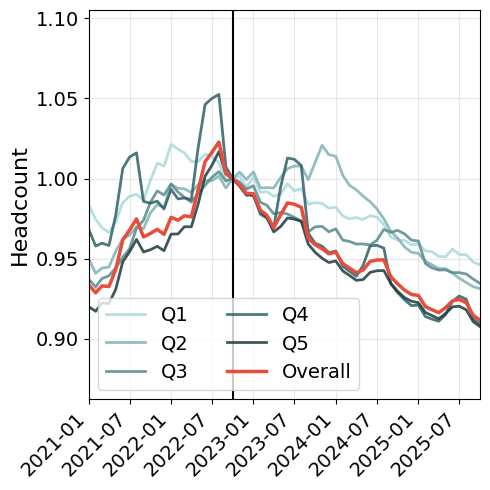


PROCESSING: π-weighted Rating Beta
Missing dv_rating: 1911869 (44.30%)
Rows after cleaning: 2,403,718


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 2,403,718
Panel data created: 51,852 rows
Saved: images/early_career2_pi_dv_rating_beta.pdf


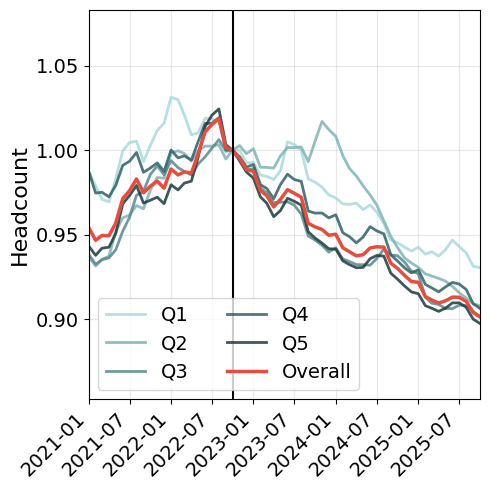


PROCESSING: π-weighted Sentiment Rating
Missing dv_rating: 931391 (21.58%)
Rows after cleaning: 3,384,196


/var/folders/pb/dksvs4d50595pbp4tlw5hv4r0000gn/T/ipykernel_71211/2654093298.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_df_clean['quintile'] = company_df_clean['onet_code'].map(quintile_mapping)


Employees with quintiles: 3,384,196
Panel data created: 52,200 rows
Saved: images/early_career2_pierre_dv_rating.pdf


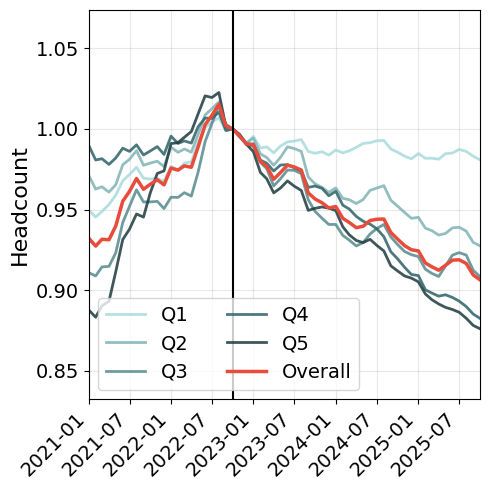

In [ ]:
def plot_single_seniority(panel_all, exposure_title, seniority_level=2, outdir="images", filename_stub=None):
    seniority_labels = {
        1: "Early Career 1",
        2: "Early Career 2",
        3: "Developing",
        4: "Mid-Career 1",
        5: "Mid-Career 2",
        6: "Senior"
    }
    baseline_date = pd.Timestamp("2022-10-01")

    colors = {
        1: "#A8DADC",
        2: "#80B3B5",
        3: "#578A8D",
        4: "#2E6166",
        5: "#1D3A3D"
    }

    os.makedirs(outdir, exist_ok=True)

    baseline_mask = panel_all["month"] == baseline_date
    baseline_by_group = (
        panel_all[baseline_mask]
        .groupby(["seniority", "quintile"])["employment"]
        .sum()
        .rename("baseline_emp")
        .reset_index()
    )

    agg_df = (
        panel_all
        .groupby(["seniority", "quintile", "month"], as_index=False)["employment"]
        .sum()
        .merge(baseline_by_group, on=["seniority", "quintile"], how="left")
    )

    agg_df["normalized_headcount"] = np.where(
        agg_df["baseline_emp"] > 0,
        agg_df["employment"] / agg_df["baseline_emp"],
        np.nan
    )

    sdata = agg_df[agg_df["seniority"] == seniority_level].copy()

    fig, ax = plt.subplots(figsize=(5, 5))

    all_values = []
    for quintile in [1, 2, 3, 4, 5]:
        qdata = sdata[sdata["quintile"] == quintile].sort_values("month")
        if not qdata.empty and qdata["normalized_headcount"].notna().any():
            ax.plot(
                qdata["month"],
                qdata["normalized_headcount"],
                color=colors[quintile],
                linewidth=2,
                label=f"Q{quintile}",
                alpha=0.85
            )
            all_values.extend(qdata["normalized_headcount"].dropna().tolist())

    overall = (
        panel_all[panel_all["seniority"] == seniority_level]
        .groupby("month", as_index=False)["employment"]
        .sum()
        .sort_values("month")
    )
    base_overall = overall.loc[overall["month"] == baseline_date, "employment"]
    if not base_overall.empty and base_overall.iloc[0] > 0:
        overall["normalized"] = overall["employment"] / base_overall.iloc[0]
        ax.plot(
            overall["month"],
            overall["normalized"],
            color="#E74C3C",
            linewidth=2.5,
            label="Overall"
        )
        all_values.extend(overall["normalized"].dropna().tolist())

    ax.axvline(x=baseline_date, color="black", linestyle="-", linewidth=1.5)

    # Title removed as requested
    #ax.set_xlabel("Date", fontsize=16)
    ax.set_ylabel("Headcount", fontsize=16)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="lower left", fontsize=14, ncol=2)
    ax.set_xlim(pd.Timestamp("2021-01-01"), pd.Timestamp("2025-10-01"))
    
    # Enlarge axis tick labels
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    if all_values:
        y_min = min(all_values) * 0.95
        y_max = max(all_values) * 1.05
        ax.set_ylim(y_min, y_max)

    plt.tight_layout()

    if filename_stub is None:
        safe = "".join(ch if ch.isalnum() else "_" for ch in exposure_title).strip("_")
        filename_stub = f"early_career2_{safe}"
    
    outpath = os.path.join(outdir, f"{filename_stub}.pdf")
    fig.savefig(outpath, format='pdf', dpi=300, bbox_inches="tight")
    print(f"Saved: {outpath}")
    
    plt.show()

# Make sure company_df_raw is loaded (skip if you already ran it above)
if "company_df_raw" not in globals():
    company_df_raw = pd.read_parquet(os.path.join(notebook_dir, "..", "Data", "DOW.parquet"))

# Three exposure measures you requested
selected_exposure_keys = [
    "occ_dv_rating_beta",   # Elondou Rating Beta
    "pi_dv_rating_beta",    # π-weighted Rating Beta
    "pierre_dv_rating"      # π-weighted Sentiment Rating
]

for exposure_key in selected_exposure_keys:
    exposure_info = EXPOSURE_DATA[exposure_key]
    _, panel_all_tmp, _ = process_exposure_data(company_df_raw, exposure_info, exposure_key)

    plot_single_seniority(
        panel_all=panel_all_tmp,
        exposure_title=exposure_info["title"],
        seniority_level=2,
        outdir="Results",

        filename_stub=f"early_career2_{exposure_key}"    )